In [41]:
import os
os.chdir('/global/cfs/cdirs/des/shivamp/cosmosis2p0/cosmosis-standard-library/')
os.environ["COSMOSIS_SRC_DIR"] = "/global/cfs/cdirs/des/shivamp/cosmosis2p0/cosmosis-standard-library/"
import numpy as np
import scipy
from scipy import integrate
import matplotlib.pyplot as plt
# import camb
# from camb import model
# from jupyterthemes import jtplot
import math
import time
import h5py
import sys 
moments_path = os.path.realpath(os.path.join('/global/cfs/cdirs/des/shivamp/cosmosis2p0/cosmosis-standard-library/gen_moments/Moments_analysis/'))
sys.path.insert(0, moments_path)
import h5py as h5
import healpy as hp
import pickle
import copy
def save_obj(name, obj):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, protocol = 2)

def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)#, encoding='latin1')

# jtplot.reset()
from tqdm import tqdm




In [42]:
import cosmosis
from cosmosis.runtime.config import Inifile
from cosmosis.runtime.pipeline import LikelihoodPipeline
from scipy.stats import norm
from scipy.linalg import sqrtm
from threadpoolctl import threadpool_limits




In [43]:
# old_stdout = sys.stdout
# sys.stdout = open(os.devnull, 'w')
# pipeline = LikelihoodPipeline(Inifile("/global/cfs/cdirs/des/shivamp/cosmosis2p0/cosmosis-standard-library/gen_moments/cosmosis/ini/saveDV_LHS_params.ini", 
#     ))

# start_bz_y3fid = pipeline.start_vector()    
# results_bz_all = pipeline.run_results(start_bz_y3fid)
# sys.stdout = old_stdout




In [44]:
def QR_inverse(matrix):
    _Q, _R = np.linalg.qr(matrix)
    return np.dot(_Q, np.linalg.inv(_R.T))





In [45]:
# # old_stdout = sys.stdout
# # sys.stdout = open(os.devnull, 'w')
# pipeline = LikelihoodPipeline(Inifile("/global/cfs/cdirs/des/shivamp/cosmosis2p0/cosmosis-standard-library/gen_moments/cosmosis/ini/MOPED_params.ini", 
#     ))

# start_vec = pipeline.start_vector()    
# results_dict = pipeline.run_results(start_vec)
# # sys.stdout = old_stdout

# kp2_fid = results_dict.block[('gen_moments_theory','kp2_all_array')][indsel_kp2]
# kp3_fid = results_dict.block[('gen_moments_theory','kp3_all_array')][indsel_kp3]
# kp2_kp3_fid = results_dict.block[('gen_moments_theory','kp2_kp3_all_array')][indsel_kp2_kp3]




In [46]:
from tqdm import tqdm
def datav_deriv(num_params, delta_parm_vals_percentages, indsel_kp2, indsel_kp3, indsel_kp2_kp3):     
    
    old_stdout = sys.stdout
    sys.stdout = open(os.devnull, 'w')
    pipeline = LikelihoodPipeline(Inifile("/global/cfs/cdirs/des/shivamp/cosmosis2p0/cosmosis-standard-library/gen_moments/cosmosis/ini/MOPED_params.ini", 
        ))

    start_vec = pipeline.start_vector()    
    results_dict = pipeline.run_results(start_vec)
    kp2_fid = results_dict.block[('gen_moments_theory','kp2_all_array')][indsel_kp2]
    kp3_fid = results_dict.block[('gen_moments_theory','kp3_all_array')][indsel_kp3]
    kp2_kp3_fid = results_dict.block[('gen_moments_theory','kp2_kp3_all_array')][indsel_kp2_kp3]
    sys.stdout = old_stdout
    transf_matrix_kp2 = np.zeros((num_params,len(kp2_fid)))
    transf_matrix_kp3 = np.zeros((num_params,len(kp3_fid)))
    transf_matrix_kp2_kp3 = np.zeros((num_params,len(kp2_kp3_fid)))    

    for ji in tqdm(range(num_params)):
        
        ddh_kp2 = np.zeros((len(kp2_fid),4))
        ddh_kp3 = np.zeros((len(kp3_fid),4))
        ddh_kp2_kp3 = np.zeros((len(kp2_kp3_fid),4))        
        
        old_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')
        pipeline_ji = LikelihoodPipeline(Inifile("/global/cfs/cdirs/des/shivamp/cosmosis2p0/cosmosis-standard-library/gen_moments/cosmosis/ini/MOPED_params.ini", 
            ))

        start_vec_ji = pipeline_ji.start_vector()  
        param_fid_ji = start_vec_ji[ji]
        if param_fid_ji != 0:
            start_vec_ji[ji] = param_fid_ji*(1 - 2*delta_parm_vals_percentages[ji])
        else:
            start_vec_ji[ji] = param_fid_ji - 2*0.001
        results_dict_ji = pipeline_ji.run_results(start_vec_ji)
        ddh_kp2[:, 0] = results_dict_ji.block[('gen_moments_theory','kp2_all_array')][indsel_kp2]
        ddh_kp3[:, 0] = results_dict_ji.block[('gen_moments_theory','kp3_all_array')][indsel_kp3]        
        ddh_kp2_kp3[:, 0] = results_dict_ji.block[('gen_moments_theory','kp2_kp3_all_array')][indsel_kp2_kp3]        
        sys.stdout = old_stdout    

        old_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')
        pipeline_ji = LikelihoodPipeline(Inifile("/global/cfs/cdirs/des/shivamp/cosmosis2p0/cosmosis-standard-library/gen_moments/cosmosis/ini/MOPED_params.ini", 
            ))

        start_vec_ji = pipeline_ji.start_vector()  
        param_fid_ji = start_vec_ji[ji]
        if param_fid_ji != 0:
            start_vec_ji[ji] = param_fid_ji*(1 - delta_parm_vals_percentages[ji])
        else:
            start_vec_ji[ji] = param_fid_ji - 0.001
        results_dict_ji = pipeline_ji.run_results(start_vec_ji)       
        ddh_kp2[:, 1] = results_dict_ji.block[('gen_moments_theory','kp2_all_array')][indsel_kp2]
        ddh_kp3[:, 1] = results_dict_ji.block[('gen_moments_theory','kp3_all_array')][indsel_kp3]        
        ddh_kp2_kp3[:, 1] = results_dict_ji.block[('gen_moments_theory','kp2_kp3_all_array')][indsel_kp2_kp3]        
        sys.stdout = old_stdout 

        
        old_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')
        pipeline_ji = LikelihoodPipeline(Inifile("/global/cfs/cdirs/des/shivamp/cosmosis2p0/cosmosis-standard-library/gen_moments/cosmosis/ini/MOPED_params.ini", 
            ))
        start_vec_ji = pipeline_ji.start_vector()  
        param_fid_ji = start_vec_ji[ji]
        if param_fid_ji != 0:
            start_vec_ji[ji] = param_fid_ji*(1 + delta_parm_vals_percentages[ji])
        else:
            start_vec_ji[ji] = param_fid_ji + 0.001
        results_dict_ji = pipeline_ji.run_results(start_vec_ji)       
        ddh_kp2[:, 2] = results_dict_ji.block[('gen_moments_theory','kp2_all_array')][indsel_kp2]
        ddh_kp3[:, 2] = results_dict_ji.block[('gen_moments_theory','kp3_all_array')][indsel_kp3]        
        ddh_kp2_kp3[:, 2] = results_dict_ji.block[('gen_moments_theory','kp2_kp3_all_array')][indsel_kp2_kp3]        
        sys.stdout = old_stdout 
        
        
        old_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')
        pipeline_ji = LikelihoodPipeline(Inifile("/global/cfs/cdirs/des/shivamp/cosmosis2p0/cosmosis-standard-library/gen_moments/cosmosis/ini/MOPED_params.ini", 
            ))        
        start_vec_ji = pipeline_ji.start_vector()  
        param_fid_ji = start_vec_ji[ji]
        if param_fid_ji != 0:
            start_vec_ji[ji] = param_fid_ji*(1 + 2*delta_parm_vals_percentages[ji])
        else:
            start_vec_ji[ji] = param_fid_ji + 2*0.001

        results_dict_ji = pipeline_ji.run_results(start_vec_ji)     
        ddh_kp2[:, 3] = results_dict_ji.block[('gen_moments_theory','kp2_all_array')][indsel_kp2]
        ddh_kp3[:, 3] = results_dict_ji.block[('gen_moments_theory','kp3_all_array')][indsel_kp3]        
        ddh_kp2_kp3[:, 3] = results_dict_ji.block[('gen_moments_theory','kp2_kp3_all_array')][indsel_kp2_kp3]        
        sys.stdout = old_stdout   
        
        if param_fid_ji != 0:
            der_kp2 = -(- ddh_kp2[:,0] +8*ddh_kp2[:,1]- 8*ddh_kp2[:,2]+ ddh_kp2[:,3])/(12*param_fid_ji*delta_parm_vals_percentages[ji])
            der_kp3 = -(- ddh_kp3[:,0] +8*ddh_kp3[:,1]- 8*ddh_kp3[:,2]+ ddh_kp3[:,3])/(12*param_fid_ji*delta_parm_vals_percentages[ji])
            der_kp2_kp3 = -(- ddh_kp2_kp3[:,0] +8*ddh_kp2_kp3[:,1]- 8*ddh_kp2_kp3[:,2]+ ddh_kp2_kp3[:,3])/(12*param_fid_ji*delta_parm_vals_percentages[ji])        
        else:
            der_kp2 = -(- ddh_kp2[:,0] +8*ddh_kp2[:,1]- 8*ddh_kp2[:,2]+ ddh_kp2[:,3])/(12*0.001)
            der_kp3 = -(- ddh_kp3[:,0] +8*ddh_kp3[:,1]- 8*ddh_kp3[:,2]+ ddh_kp3[:,3])/(12*0.001)
            der_kp2_kp3 = -(- ddh_kp2_kp3[:,0] +8*ddh_kp2_kp3[:,1]- 8*ddh_kp2_kp3[:,2]+ ddh_kp2_kp3[:,3])/(12*0.001)        

        transf_matrix_kp2[ji,:]= der_kp2
        transf_matrix_kp3[ji,:]= der_kp3
        transf_matrix_kp2_kp3[ji,:]= der_kp2_kp3
        
    return transf_matrix_kp2, transf_matrix_kp3, transf_matrix_kp2_kp3 




In [47]:
from tqdm import tqdm
def data_compression(num_params, delta_parm_vals_percentages, indsel_kp2, indsel_kp3, indsel_kp2_kp3, inv_cov_kp2, inv_cov_kp3, inv_cov_kp2_kp3):     
    
    old_stdout = sys.stdout
    sys.stdout = open(os.devnull, 'w')
    pipeline = LikelihoodPipeline(Inifile("/global/cfs/cdirs/des/shivamp/cosmosis2p0/cosmosis-standard-library/gen_moments/cosmosis/ini/MOPED_params.ini", 
        ))

    start_vec = pipeline.start_vector()    
    results_dict = pipeline.run_results(start_vec)
    kp2_fid = results_dict.block[('gen_moments_theory','kp2_all_array')][indsel_kp2]
    kp3_fid = results_dict.block[('gen_moments_theory','kp3_all_array')][indsel_kp3]
    kp2_kp3_fid = results_dict.block[('gen_moments_theory','kp2_kp3_all_array')][indsel_kp2_kp3]
    sys.stdout = old_stdout
    transf_matrix_kp2 = np.zeros((num_params,len(kp2_fid)))
    transf_matrix_kp3 = np.zeros((num_params,len(kp3_fid)))
    transf_matrix_kp2_kp3 = np.zeros((num_params,len(kp2_kp3_fid)))    

    for ji in tqdm(range(num_params)):
        
        ddh_kp2 = np.zeros((len(kp2_fid),4))
        ddh_kp3 = np.zeros((len(kp3_fid),4))
        ddh_kp2_kp3 = np.zeros((len(kp2_kp3_fid),4))        
        
        old_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')
        pipeline_ji = LikelihoodPipeline(Inifile("/global/cfs/cdirs/des/shivamp/cosmosis2p0/cosmosis-standard-library/gen_moments/cosmosis/ini/MOPED_params.ini", 
            ))

        start_vec_ji = pipeline_ji.start_vector()  
        param_fid_ji = start_vec_ji[ji]
        if param_fid_ji != 0:
            start_vec_ji[ji] = param_fid_ji*(1 - 2*delta_parm_vals_percentages[ji])
        else:
            start_vec_ji[ji] = param_fid_ji - 2*0.001
        results_dict_ji = pipeline_ji.run_results(start_vec_ji)
        ddh_kp2[:, 0] = results_dict_ji.block[('gen_moments_theory','kp2_all_array')][indsel_kp2]
        ddh_kp3[:, 0] = results_dict_ji.block[('gen_moments_theory','kp3_all_array')][indsel_kp3]        
        ddh_kp2_kp3[:, 0] = results_dict_ji.block[('gen_moments_theory','kp2_kp3_all_array')][indsel_kp2_kp3]        
        sys.stdout = old_stdout    

        old_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')
        pipeline_ji = LikelihoodPipeline(Inifile("/global/cfs/cdirs/des/shivamp/cosmosis2p0/cosmosis-standard-library/gen_moments/cosmosis/ini/MOPED_params.ini", 
            ))

        start_vec_ji = pipeline_ji.start_vector()  
        param_fid_ji = start_vec_ji[ji]
        if param_fid_ji != 0:
            start_vec_ji[ji] = param_fid_ji*(1 - delta_parm_vals_percentages[ji])
        else:
            start_vec_ji[ji] = param_fid_ji - 0.001
        results_dict_ji = pipeline_ji.run_results(start_vec_ji)       
        ddh_kp2[:, 1] = results_dict_ji.block[('gen_moments_theory','kp2_all_array')][indsel_kp2]
        ddh_kp3[:, 1] = results_dict_ji.block[('gen_moments_theory','kp3_all_array')][indsel_kp3]        
        ddh_kp2_kp3[:, 1] = results_dict_ji.block[('gen_moments_theory','kp2_kp3_all_array')][indsel_kp2_kp3]        
        sys.stdout = old_stdout 

        
        old_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')
        pipeline_ji = LikelihoodPipeline(Inifile("/global/cfs/cdirs/des/shivamp/cosmosis2p0/cosmosis-standard-library/gen_moments/cosmosis/ini/MOPED_params.ini", 
            ))
        start_vec_ji = pipeline_ji.start_vector()  
        param_fid_ji = start_vec_ji[ji]
        if param_fid_ji != 0:
            start_vec_ji[ji] = param_fid_ji*(1 + delta_parm_vals_percentages[ji])
        else:
            start_vec_ji[ji] = param_fid_ji + 0.001
        results_dict_ji = pipeline_ji.run_results(start_vec_ji)       
        ddh_kp2[:, 2] = results_dict_ji.block[('gen_moments_theory','kp2_all_array')][indsel_kp2]
        ddh_kp3[:, 2] = results_dict_ji.block[('gen_moments_theory','kp3_all_array')][indsel_kp3]        
        ddh_kp2_kp3[:, 2] = results_dict_ji.block[('gen_moments_theory','kp2_kp3_all_array')][indsel_kp2_kp3]        
        sys.stdout = old_stdout 
        
        
        old_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')
        pipeline_ji = LikelihoodPipeline(Inifile("/global/cfs/cdirs/des/shivamp/cosmosis2p0/cosmosis-standard-library/gen_moments/cosmosis/ini/MOPED_params.ini", 
            ))        
        start_vec_ji = pipeline_ji.start_vector()  
        param_fid_ji = start_vec_ji[ji]
        if param_fid_ji != 0:
            start_vec_ji[ji] = param_fid_ji*(1 + 2*delta_parm_vals_percentages[ji])
        else:
            start_vec_ji[ji] = param_fid_ji + 2*0.001

        results_dict_ji = pipeline_ji.run_results(start_vec_ji)     
        ddh_kp2[:, 3] = results_dict_ji.block[('gen_moments_theory','kp2_all_array')][indsel_kp2]
        ddh_kp3[:, 3] = results_dict_ji.block[('gen_moments_theory','kp3_all_array')][indsel_kp3]        
        ddh_kp2_kp3[:, 3] = results_dict_ji.block[('gen_moments_theory','kp2_kp3_all_array')][indsel_kp2_kp3]        
        sys.stdout = old_stdout   
        
        if param_fid_ji != 0:
            der_kp2 = -(- ddh_kp2[:,0] +8*ddh_kp2[:,1]- 8*ddh_kp2[:,2]+ ddh_kp2[:,3])/(12*param_fid_ji*delta_parm_vals_percentages[ji])
            der_kp3 = -(- ddh_kp3[:,0] +8*ddh_kp3[:,1]- 8*ddh_kp3[:,2]+ ddh_kp3[:,3])/(12*param_fid_ji*delta_parm_vals_percentages[ji])
            der_kp2_kp3 = -(- ddh_kp2_kp3[:,0] +8*ddh_kp2_kp3[:,1]- 8*ddh_kp2_kp3[:,2]+ ddh_kp2_kp3[:,3])/(12*param_fid_ji*delta_parm_vals_percentages[ji])        
        else:
            der_kp2 = -(- ddh_kp2[:,0] +8*ddh_kp2[:,1]- 8*ddh_kp2[:,2]+ ddh_kp2[:,3])/(12*0.001)
            der_kp3 = -(- ddh_kp3[:,0] +8*ddh_kp3[:,1]- 8*ddh_kp3[:,2]+ ddh_kp3[:,3])/(12*0.001)
            der_kp2_kp3 = -(- ddh_kp2_kp3[:,0] +8*ddh_kp2_kp3[:,1]- 8*ddh_kp2_kp3[:,2]+ ddh_kp2_kp3[:,3])/(12*0.001)        

        transf_matrix_kp2[ji,:]= np.matmul(der_kp2,inv_cov_kp2).T
        transf_matrix_kp3[ji,:]= np.matmul(der_kp3,inv_cov_kp3).T
        transf_matrix_kp2_kp3[ji,:]= np.matmul(der_kp2_kp3,inv_cov_kp2_kp3).T        
        
    return transf_matrix_kp2, transf_matrix_kp3, transf_matrix_kp2_kp3 




In [48]:
def filter_full_data(data_full, params):
    filter_type = params['type']
    
    sm_all = data_full['sm_all']
    id_kp2_all_finite = data_full['id_kp2_all_finite'][0,:,:].T
    ind_filter_kp2 = []
    for jid in range(len(id_kp2_all_finite)):
        jz1, jz2, i, j = id_kp2_all_finite[jid]
        
        if filter_type == 'auto_zbin':
            if jz1 == jz2:
                ind_filter_kp2.append(jid)
                
        if filter_type == 'auto_zbin_ltsc':
            if jz1 == jz2:
                sc_all = params['sc_all']    
                sc_jz_all = np.array([sc_all[jz1], sc_all[jz2]])
                sc_jz_max = np.amax(sc_jz_all)
                # if (sm_all[i] > sc_all[jz1]) & (sm_all[j] > sc_all[jz2]):
                if (sm_all[i] < sc_jz_max) & (sm_all[j] < sc_jz_max):
                    ind_filter_kp2.append(jid)                
                
                
        if filter_type == 'simple_test':
            if (jz1 == jz2) and (jz2==3) and (i==j):
                ind_filter_kp2.append(jid)
                

        if filter_type == 'auto_smbin':
            if i == j:
                ind_filter_kp2.append(jid)

        if filter_type == 'auto_zbin_gtsc':
            sc_all = params['sc_all']
            if jz1 == jz2:
                sc_jz_all = np.array([sc_all[jz1], sc_all[jz2]])
                sc_jz_max = np.amax(sc_jz_all)
                # if (sm_all[i] > sc_all[jz1]) & (sm_all[j] > sc_all[jz2]):
                if (sm_all[i] > sc_jz_max) & (sm_all[j] > sc_jz_max):                
                    ind_filter_kp2.append(jid)

        if filter_type == 'auto_smbin_gtsc':
            sc_all = params['sc_all']            
            if i == j:
                sc_jz_all = np.array([sc_all[jz1], sc_all[jz2]])
                sc_jz_max = np.amax(sc_jz_all)
                # if (sm_all[i] > sc_all[jz1]) & (sm_all[j] > sc_all[jz2]):
                if (sm_all[i] > sc_jz_max) & (sm_all[j] > sc_jz_max):                
                    ind_filter_kp2.append(jid)

                    
        if filter_type == 'auto_smbin_ltsc':
            sc_all = params['sc_all']            
            if i == j:
                sc_jz_all = np.array([sc_all[jz1], sc_all[jz2]])
                sc_jz_max = np.amax(sc_jz_all)
                # if (sm_all[i] > sc_all[jz1]) & (sm_all[j] > sc_all[jz2]):
                if (sm_all[i] < sc_jz_max) & (sm_all[j] < sc_jz_max):                
                    ind_filter_kp2.append(jid)

        if filter_type == 'auto_zbin_smbin_ltsc':
            sc_all = params['sc_all']            
            if (i == j) and (jz1 == jz2):
                sc_jz_all = np.array([sc_all[jz1], sc_all[jz2]])
                sc_jz_max = np.amax(sc_jz_all)
                # if (sm_all[i] > sc_all[jz1]) & (sm_all[j] > sc_all[jz2]):
                if (sm_all[i] < sc_jz_max) & (sm_all[j] < sc_jz_max):                
                    ind_filter_kp2.append(jid)
                    
                    
        if filter_type == 'all_gtsc':
            sc_all = params['sc_all']    
            sc_jz_all = np.array([sc_all[jz1], sc_all[jz2]])
            sc_jz_max = np.amax(sc_jz_all)
            # if (sm_all[i] > sc_all[jz1]) & (sm_all[j] > sc_all[jz2]):
            if (sm_all[i] > sc_jz_max) & (sm_all[j] > sc_jz_max):
                ind_filter_kp2.append(jid)
                
        if filter_type == 'all_ltsc':
            sc_all = params['sc_all']    
            sc_jz_all = np.array([sc_all[jz1], sc_all[jz2]])
            sc_jz_max = np.amax(sc_jz_all)
            # if (sm_all[i] > sc_all[jz1]) & (sm_all[j] > sc_all[jz2]):
            if (sm_all[i] < sc_jz_max) & (sm_all[j] < sc_jz_max):
                ind_filter_kp2.append(jid)                
                
        if filter_type == 'all':
            ind_filter_kp2.append(jid)
        
    ind_filter_kp2 = np.array(ind_filter_kp2)
    # data_kp2_lhs_filter = data_full['kp2_all_lhs'][:, ind_filter_kp2]

    id_kp3_all_finite = data_full['id_kp3_all_finite'][0,:,:].T
    ind_filter_kp3 = []
    for jid in range(len(id_kp3_all_finite)):
        jz1, jz2, jz3, i, j, k = id_kp3_all_finite[jid]
        if filter_type == 'auto_zbin':
            if (jz1 == jz2) and (jz2 == jz3):
                ind_filter_kp3.append(jid)
                
        if filter_type == 'auto_zbin_ltsc':
            if (jz1 == jz2) and (jz2 == jz3):
                sc_all = params['sc_all']         
                sc_jz_all = np.array([sc_all[jz1], sc_all[jz2], sc_all[jz3]])
                sc_jz_max = np.amax(sc_jz_all)
                # if (sm_all[i] > sc_all[jz1]) & (sm_all[j] > sc_all[jz2]) & (sm_all[k] > sc_all[jz3]):
                if (sm_all[i] < sc_jz_max) & (sm_all[j] < sc_jz_max) & (sm_all[k] < sc_jz_max):                    
                    ind_filter_kp3.append(jid)                                
                
        if filter_type == 'simple_test':
            if (jz1 == jz2) and (jz2==jz3) and (jz2==3) and (i==j) and (j==k):
                ind_filter_kp3.append(jid)
                
        if filter_type == 'auto_smbin':
            if (i == j) and (j == k):
                ind_filter_kp3.append(jid)

        if filter_type == 'auto_zbin_gtsc':
            sc_all = params['sc_all']
            if (jz1 == jz2) and (jz2 == jz3):
                sc_jz_all = np.array([sc_all[jz1], sc_all[jz2], sc_all[jz3]])
                sc_jz_max = np.amax(sc_jz_all)
                # if (sm_all[i] > sc_all[jz1]) & (sm_all[j] > sc_all[jz2]) & (sm_all[k] > sc_all[jz3]):
                if (sm_all[i] > sc_jz_max) & (sm_all[j] > sc_jz_max) & (sm_all[k] > sc_jz_max):                    
                    ind_filter_kp3.append(jid)

        if filter_type == 'auto_smbin_gtsc':
            sc_all = params['sc_all']            
            if (i == j) and (j == k):
                sc_jz_all = np.array([sc_all[jz1], sc_all[jz2], sc_all[jz3]])
                sc_jz_max = np.amax(sc_jz_all)
                # if (sm_all[i] > sc_all[jz1]) & (sm_all[j] > sc_all[jz2]) & (sm_all[k] > sc_all[jz3]):
                if (sm_all[i] > sc_jz_max) & (sm_all[j] > sc_jz_max) & (sm_all[k] > sc_jz_max):                    
                    ind_filter_kp3.append(jid)

        if filter_type == 'auto_smbin_ltsc':
            sc_all = params['sc_all']            
            if (i == j) and (j == k):
                sc_jz_all = np.array([sc_all[jz1], sc_all[jz2], sc_all[jz3]])
                sc_jz_max = np.amax(sc_jz_all)
                # if (sm_all[i] > sc_all[jz1]) & (sm_all[j] > sc_all[jz2]) & (sm_all[k] > sc_all[jz3]):
                if (sm_all[i] < sc_jz_max) & (sm_all[j] < sc_jz_max) & (sm_all[k] < sc_jz_max):                    
                    ind_filter_kp3.append(jid)
 
        if filter_type == 'auto_zbin_smbin_ltsc':
            sc_all = params['sc_all']            
            if (i == j) and (j == k) and (jz1 == jz2) and (jz2 == jz3):
                sc_jz_all = np.array([sc_all[jz1], sc_all[jz2], sc_all[jz3]])
                sc_jz_max = np.amax(sc_jz_all)
                # if (sm_all[i] > sc_all[jz1]) & (sm_all[j] > sc_all[jz2]) & (sm_all[k] > sc_all[jz3]):
                if (sm_all[i] < sc_jz_max) & (sm_all[j] < sc_jz_max) & (sm_all[k] < sc_jz_max):                    
                    ind_filter_kp3.append(jid)

        if filter_type == 'all_gtsc':
            sc_all = params['sc_all']         
            sc_jz_all = np.array([sc_all[jz1], sc_all[jz2], sc_all[jz3]])
            sc_jz_max = np.amax(sc_jz_all)
            # if (sm_all[i] > sc_all[jz1]) & (sm_all[j] > sc_all[jz2]) & (sm_all[k] > sc_all[jz3]):
            if (sm_all[i] > sc_jz_max) & (sm_all[j] > sc_jz_max) & (sm_all[k] > sc_jz_max):                    
                ind_filter_kp3.append(jid)
                
        if filter_type == 'all_ltsc':
            sc_all = params['sc_all']         
            sc_jz_all = np.array([sc_all[jz1], sc_all[jz2], sc_all[jz3]])
            sc_jz_max = np.amax(sc_jz_all)
            # if (sm_all[i] > sc_all[jz1]) & (sm_all[j] > sc_all[jz2]) & (sm_all[k] > sc_all[jz3]):
            if (sm_all[i] < sc_jz_max) & (sm_all[j] < sc_jz_max) & (sm_all[k] < sc_jz_max):                    
                ind_filter_kp3.append(jid)                

                
        if filter_type == 'all':
            ind_filter_kp3.append(jid)
        
    ind_filter_kp3 = np.array(ind_filter_kp3)
    # data_kp3_lhs_filter = data_full['kp3_all_lhs'][:, ind_filter_kp3]

    return ind_filter_kp2, ind_filter_kp3
    



In [49]:
# _, _, ind_filter_kp2, ind_filter_kp3 = filter_full_data(data_full, params_filter)




In [50]:
jr_lhs = 0
nsamp_lhs = 20000
sdir = '/global/cfs/cdirs/des/shivamp/cosmosis2p0/cosmosis-standard-library/saveDVs/'
# data_full = pk.load(open(sdir + 'newIA/' + 'COMBINED_lhs_n' + str(nsamp_lhs) + '_jr' + str(jr_lhs) + '.pk','rb'))
# fname = sdir + 'OmAsonly/' + 'COMBINED_lhs_n' + str(nsamp_lhs) + '_jr' + str(jr_lhs) + '.pk'
# fname = sdir + 'OmAsonly/' + 'COMBINED_lhs_n' + str(nsamp_lhs) + '_jr' + str(jr_lhs) + '.pk'
fname = sdir + 'OmAsnarrow/' + 'COMBINED_lhs_n' + str(nsamp_lhs) + '_jr' + str(jr_lhs) + '.pk'
# np.save(fname, saved, allow_pickle=True)
import h5py
hf = h5py.File(fname, 'r')




In [51]:
data_full = {'kp2_all_lhs':hf['kp2_all_lhs'], 'kp3_all_lhs':hf['kp3_all_lhs'], 
         'id_kp2_all_finite':hf['id_kp2_all_finite'],
        'id_kp3_all_finite':hf['id_kp3_all_finite'],
         'sm_all':hf['sm_all']
        }




In [86]:
sc_all = [45.0, 28.0, 18.0, 18.0]
# sc_all = [35.0, 35.0, 35.0, 35.0]

# params_filter = {'type':'auto_smbin_gtsc', 'sc_all':sc_all}
params_filter = {'type':'all_gtsc', 'sc_all':sc_all}
# params_filter = {'type':'all_ltsc', 'sc_all':[35.0, 35.0, 35.0, 35.0]}
# params_filter = {'type':'auto_smbin_ltsc', 'sc_all':[35.0, 35.0, 35.0, 35.0]}
# params_filter = {'type':'auto_zbin_smbin_ltsc', 'sc_all':[35.0, 35.0, 35.0, 35.0]}
# params_filter = {'type':'auto_zbin_ltsc', 'sc_all':[35.0, 35.0, 35.0, 35.0]}
# params_filter = {'type':'all', 'sc_all':sc_all}
# params_filter = {'type':'simple_test', 'sc_all':sc_all}
# var_th = 0.9999999
# df = pk.load(open('/global/cfs/cdirs/des/shivamp/cosmosis2p0/cosmosis-standard-library/gen_moments/fid_sim_measurements.pk','rb'))  
df = pk.load(open('/global/cfs/cdirs/des/shivamp/cosmosis2p0/cosmosis-standard-library/gen_moments/fid_sim_measurements_cosmogrid_constrained_rot.pk','rb'))  

# saved = {'kp2_all_fid':kp2_all_fid, 'kp3_all_fid':kp3_all_fid, 'kp3_all_data':kp3_all_data, 'kp2_all_data':kp2_all_data}
kp2_all_fid = df['kp2_all_fid']
kp3_all_fid = df['kp3_all_fid']
kp3_all_data = df['kp3_all_data']
kp2_all_data = df['kp2_all_data']
kp2_kp3_all_data = np.hstack((kp2_all_data, kp3_all_data))
kp2_kp3_all_fid = np.concatenate((kp2_all_fid, kp3_all_fid))

ind_filter_kp2, ind_filter_kp3 = filter_full_data(data_full, params_filter)
ind_filter_kp2_kp3 = np.concatenate((ind_filter_kp2, hf['kp2_all_lhs'].shape[1] + ind_filter_kp3))

mean_kp2sims = np.mean(kp2_all_data.T, axis=1)
mean_kp3sims = np.mean(kp3_all_data.T, axis=1)
mean_kp2kp3sims = np.mean(kp2_kp3_all_data.T, axis=1)




In [87]:
# ind_filter_kp2
kp3_all_data.shape, 


((1418, 2400),)

In [88]:
len(ind_filter_kp2), len(ind_filter_kp3)


(148, 634)

In [89]:
# cov_mat_kp2sims = np.cov(kp2_all_data[:,ind_filter_kp2].T)
# invcovmat_kp2sims = np.linalg.inv(cov_mat_kp2sims)
# snr_kp2_orig = np.sqrt(np.matmul(mean_kp2sims[ind_filter_kp2],np.matmul(invcovmat_kp2sims, mean_kp2sims[ind_filter_kp2].T)))
# print(snr_kp2_orig)



In [90]:
cov_mat_kp2sims = np.cov(kp2_all_data[:,ind_filter_kp2].T) + 0.01*np.diag(np.diag(np.cov(kp2_all_data[:,ind_filter_kp2].T)))
invcovmat_kp2sims = QR_inverse(cov_mat_kp2sims)
snr_kp2_orig = np.sqrt(np.matmul(mean_kp2sims[ind_filter_kp2],np.matmul(invcovmat_kp2sims, mean_kp2sims[ind_filter_kp2].T)))
print(snr_kp2_orig)




In [91]:
# snr_kp3_orig 


In [92]:
# cov_mat_kp3sims = np.cov(kp3_all_data[:,ind_filter_kp3].T)
# invcovmat_kp3sims = np.linalg.inv(cov_mat_kp3sims)
# snr_kp3_orig = np.sqrt(np.matmul(mean_kp3sims[ind_filter_kp3],np.matmul(invcovmat_kp3sims, mean_kp3sims[ind_filter_kp3].T)))
# print(snr_kp3_orig)



In [93]:
cov_mat_kp3sims = np.cov(kp3_all_data[:,ind_filter_kp3].T) + 0.01*np.diag(np.diag(np.cov(kp3_all_data[:,ind_filter_kp3].T)))
invcovmat_kp3sims = QR_inverse(cov_mat_kp3sims)
snr_kp3_orig = np.sqrt(np.matmul(mean_kp3sims[ind_filter_kp3],np.matmul(invcovmat_kp3sims, mean_kp3sims[ind_filter_kp3].T)))
print(snr_kp3_orig)




In [94]:
old_stdout = sys.stdout
sys.stdout = open(os.devnull, 'w')
pipeline = LikelihoodPipeline(Inifile("/global/cfs/cdirs/des/shivamp/cosmosis2p0/cosmosis-standard-library/gen_moments/cosmosis/ini/MOPED_params.ini", 
    ))

start_vec = pipeline.start_vector()    
results_dict = pipeline.run_results(start_vec)
kp2_fid = results_dict.block[('gen_moments_theory','kp2_all_array')][ind_filter_kp2]
kp3_fid = results_dict.block[('gen_moments_theory','kp3_all_array')][ind_filter_kp3]
kp2_kp3_fid = results_dict.block[('gen_moments_theory','kp2_kp3_all_array')][ind_filter_kp2_kp3]
sys.stdout = old_stdout




In [95]:
len(start_vec)



16

In [96]:

# # np.amin(np.diag(cov_mat_kp3sims))

# num_params = len(start_vec)
# delta_parm_vals_percentages = 0.005*np.ones(num_params)

# deriv_matrix_kp2, deriv_matrix_kp3, deriv_matrix_kp2_kp3  = \
# datav_deriv(num_params, delta_parm_vals_percentages, ind_filter_kp2, ind_filter_kp3, ind_filter_kp2_kp3)






In [97]:
# old_stdout = sys.stdout
# sys.stdout = open(os.devnull, 'w')
# pipeline = LikelihoodPipeline(Inifile("/global/cfs/cdirs/des/shivamp/cosmosis2p0/cosmosis-standard-library/gen_moments/cosmosis/ini/MOPED_params.ini", 
#     ))

# start_vec = pipeline.start_vector()    
# results_dict = pipeline.run_results(start_vec)
# kp2_fid = results_dict.block[('gen_moments_theory','kp2_all_array')][ind_filter_kp2]
# kp3_fid = results_dict.block[('gen_moments_theory','kp3_all_array')][ind_filter_kp3]
# kp2_kp3_fid = results_dict.block[('gen_moments_theory','kp2_kp3_all_array')][ind_filter_kp2_kp3]
# sys.stdout = old_stdout


# num_p = len(start_vec)
# start_vec_mat = np.tile(start_vec.reshape(num_p, 1), (1, len(kp2_fid)))
# kp2_fid_mat = np.tile(kp2_fid.reshape(1, len(kp2_fid)), (num_p, 1))
# dlogkp2_dlogparams = start_vec_mat*deriv_matrix_kp2/kp2_fid_mat

# start_vec_mat = np.tile(start_vec.reshape(num_p, 1), (1, len(kp3_fid)))
# kp3_fid_mat = np.tile(kp3_fid.reshape(1, len(kp3_fid)), (num_p, 1))
# dlogkp3_dlogparams = start_vec_mat*deriv_matrix_kp3/kp3_fid_mat




In [98]:
# saved = {'dlogkp2_dlogparams':dlogkp2_dlogparams, 'dlogkp3_dlogparams':dlogkp3_dlogparams}
# pk.dump(saved, open('log_derv_allparams.pk','wb'))




In [99]:
# # cov_mat_kp2kp3sims = np.cov(kp2_kp3_all_data[:,ind_filter_kp2_kp3].T)
# # invcovmat_kp2kp3sims = np.linalg.inv(cov_mat_kp2kp3sims)
# # snr_kp2kp3_orig = np.sqrt(np.matmul(mean_kp2kp3sims[ind_filter_kp2_kp3],np.matmul(invcovmat_kp2kp3sims, mean_kp2kp3sims[ind_filter_kp2_kp3].T)))
# # print(snr_kp2kp3_orig
# pl.figure()
# pl.plot(dlogkp2_dlogparams[0,:])
# pl.savefig('try_logder.pdf')
# pl.show()




In [100]:
# cov_mat_kp2kp3sims = np.cov(kp2_kp3_all_data[:,ind_filter_kp2_kp3].T)
cov_mat_kp2kp3sims = np.cov(kp2_kp3_all_data[:,ind_filter_kp2_kp3].T) + 0.01*np.diag(np.diag(np.cov(kp2_kp3_all_data[:,ind_filter_kp2_kp3].T)))
invcovmat_kp2kp3sims = QR_inverse(cov_mat_kp2kp3sims)
snr_kp2kp3_orig = np.sqrt(np.matmul(mean_kp2kp3sims[ind_filter_kp2_kp3],np.matmul(invcovmat_kp2kp3sims, mean_kp2kp3sims[ind_filter_kp2_kp3].T)))
print(snr_kp2kp3_orig)




In [101]:
# num_params = 2
# delta_parm_vals_percentages = [0.005, 0.005]

# num_params = 16
num_params = len(start_vec)
delta_parm_vals_percentages = 0.005*np.ones(num_params)

transf_matrix_kp2, transf_matrix_kp3, transf_matrix_kp2_kp3  = \
data_compression(num_params, delta_parm_vals_percentages, ind_filter_kp2, ind_filter_kp3, ind_filter_kp2_kp3, invcovmat_kp2sims, invcovmat_kp3sims, invcovmat_kp2kp3sims)







100%|██████████| 16/16 [23:04<00:00, 86.54s/it]


In [102]:
# transf_matrix_kp2.shape
kp2_transf_mat = np.dot(transf_matrix_kp2,kp2_all_data[:,ind_filter_kp2].T)
kp3_transf_mat = np.dot(transf_matrix_kp3,kp3_all_data[:,ind_filter_kp3].T)
kp2_kp3_transf_mat = np.dot(transf_matrix_kp2_kp3,kp2_kp3_all_data[:,ind_filter_kp2_kp3].T)




In [103]:
# kp2_transf_mat.shape
kp2_transf_mean = np.mean(kp2_transf_mat, axis=1)
kp3_transf_mean = np.mean(kp3_transf_mat, axis=1)
kp2_kp3_transf_mean = np.mean(kp2_kp3_transf_mat, axis=1)



In [104]:
cov_kp2_tranf_mat = np.cov(kp2_transf_mat)
invcov_kp2_tranf_mat = np.linalg.inv(cov_kp2_tranf_mat)
np.sqrt(np.matmul(kp2_transf_mean,np.matmul(invcov_kp2_tranf_mat, kp2_transf_mean.T)))




22.22493210460063

In [105]:
cov_kp3_tranf_mat = np.cov(kp3_transf_mat)
invcov_kp3_tranf_mat = np.linalg.inv(cov_kp3_tranf_mat)
np.sqrt(np.matmul(kp3_transf_mean,np.matmul(invcov_kp3_tranf_mat, kp3_transf_mean.T)))




6.775682461692714

In [106]:
cov_kp2kp3_tranf_mat = np.cov(kp2_kp3_transf_mat)
invcov_kp2kp3_tranf_mat = QR_inverse(cov_kp2kp3_tranf_mat)
np.sqrt(np.matmul(kp2_kp3_transf_mean,np.matmul(invcov_kp2kp3_tranf_mat, kp2_kp3_transf_mean.T)))




26.509297343361858

In [107]:
old_stdout = sys.stdout
sys.stdout = open(os.devnull, 'w')
pipeline = LikelihoodPipeline(Inifile("/global/cfs/cdirs/des/shivamp/cosmosis2p0/cosmosis-standard-library/gen_moments/cosmosis/ini/MOPED_params.ini", 
    ))

start_vec = pipeline.start_vector()    
results_dict = pipeline.run_results(start_vec)
kp2_fid = results_dict.block[('gen_moments_theory','kp2_all_array')][ind_filter_kp2]
kp3_fid = results_dict.block[('gen_moments_theory','kp3_all_array')][ind_filter_kp3]
kp2_kp3_fid = results_dict.block[('gen_moments_theory','kp2_kp3_all_array')][ind_filter_kp2_kp3]
sys.stdout = old_stdout



In [108]:
# transf_matrix_kp2.shape
kp2_transf_fid = np.dot(transf_matrix_kp2,kp2_fid.T)
kp3_transf_fid = np.dot(transf_matrix_kp3,kp3_fid.T)
kp2_kp3_transf_fid = np.dot(transf_matrix_kp2_kp3,kp2_kp3_fid.T)






In [109]:
(kp2_transf_fid - kp2_transf_mean)/kp2_transf_fid
# kp2_transf_fid


array([-4.61870181e-02,  4.17018925e-02,  1.64249659e-02,  4.22335096e+00,
        9.48146036e-02,  3.32184978e-02,  1.07671931e+00, -1.97565743e+00,
        2.23746252e-01,  5.32841268e-02,  9.24841419e-01,  1.42783668e+02,
        2.21052105e-01,  1.58924576e-01,  1.20415891e+00,  1.67117784e+00])

In [110]:
saved = {'transf_matrix_kp2':transf_matrix_kp2, 'transf_matrix_kp3':transf_matrix_kp3, 'transf_matrix_kp2_kp3':transf_matrix_kp2_kp3,
        'kp2_transf_mean':kp2_transf_mean, 'kp3_transf_mean':kp3_transf_mean, 'kp2_kp3_transf_mean':kp2_kp3_transf_mean,
         'kp2_transf_fid':kp2_transf_fid, 'kp3_transf_fid':kp3_transf_fid, 'kp2_kp3_transf_fid':kp2_kp3_transf_fid,
        'cov_kp2_tranf_mat':cov_kp2_tranf_mat, 'cov_kp3_tranf_mat':cov_kp3_tranf_mat, 'cov_kp2kp3_tranf_mat':cov_kp2kp3_tranf_mat,
         'ind_filter_kp2':ind_filter_kp2, 'ind_filter_kp3':ind_filter_kp3, 'ind_filter_kp2_kp3':ind_filter_kp2_kp3
        }

# pk.dump(saved, open('measurements_allparams_auto_smbin_gtsc_MOPED_inf1p_cosmogrid.pk','wb'))
pk.dump(saved, open('measurements_allparams_all_gtsc_MOPED_inf1p_cosmogrid.pk','wb'))

# pk.dump(saved, open('measurements_OmAsonly_auto_smbin_gtsc_MOPED_inf15p.pk','wb'))
# pk.dump(saved, open('measurements_OmAsonly_all_gtsc_MOPED_inf15p.pk','wb'))


# pk.dump(saved, open('measurements_OmAsonly_auto_smbin_ltsc_MOPED_inf15p.pk','wb'))
# pk.dump(saved, open('measurements_OmAsonly_all_ltsc_MOPED_inf15p.pk','wb'))

# pk.dump(saved, open('measurements_OmAsonly_auto_zbin_smbin_ltsc_MOPED_inf15p.pk','wb'))
# pk.dump(saved, open('measurements_OmAsonly_auto_zbin_ltsc_MOPED_inf15p.pk','wb'))


# dill.dump(saved, open('measurements_OmAsonly_all_ncomp60.pk','wb'))






In [53]:
# 2+2



4

In [111]:
# transf_matrix_kp2_kp3.shape
pl.rcParams.update({
    "text.usetex": False,
    # "font.family": "sans-serif",
    # "font.sans-serif": ["Helvetica"]
})


In [112]:
# exp_var_kp2
# pca_kp2.explained_variance_
# snr_kp2_orig_all

inf_vals = np.linspace(0,1.0,100)
snr_kp3_all = np.zeros_like(inf_vals)
snr_kp2_all = np.zeros_like(inf_vals)
snr_kp2_kp3_all = np.zeros_like(inf_vals)


for ji in tqdm(range(len(inf_vals))):
    cov_mat_kp2sims = np.cov(kp2_all_data[:,ind_filter_kp2].T) + inf_vals[ji]*np.diag(np.diag(np.cov(kp2_all_data[:,ind_filter_kp2].T)))
    invcovmat_kp2sims = QR_inverse(cov_mat_kp2sims)
    snr_kp2_all[ji] = np.sqrt(np.matmul(mean_kp2sims[ind_filter_kp2],np.matmul(invcovmat_kp2sims, mean_kp2sims[ind_filter_kp2].T)))

        
    cov_mat_kp3sims = np.cov(kp3_all_data[:,ind_filter_kp3].T) + inf_vals[ji]*np.diag(np.diag(np.cov(kp3_all_data[:,ind_filter_kp3].T)))
    invcovmat_kp3sims = QR_inverse(cov_mat_kp3sims)
    snr_kp3_all[ji] = np.sqrt(np.matmul(mean_kp3sims[ind_filter_kp3],np.matmul(invcovmat_kp3sims, mean_kp3sims[ind_filter_kp3].T)))
    # print(snr_kp3_orig)


    cov_mat_kp2kp3sims = np.cov(kp2_kp3_all_data[:,ind_filter_kp2_kp3].T) + inf_vals[ji]*np.diag(np.diag(np.cov(kp2_kp3_all_data[:,ind_filter_kp2_kp3].T)))
    invcovmat_kp2kp3sims = QR_inverse(cov_mat_kp2kp3sims)
    snr_kp2_kp3_all[ji] = np.sqrt(np.matmul(mean_kp2kp3sims[ind_filter_kp2_kp3],np.matmul(invcovmat_kp2kp3sims, mean_kp2kp3sims[ind_filter_kp2_kp3].T)))







100%|██████████| 100/100 [00:34<00:00,  2.88it/s]


In [113]:
# snr_kp3_all

sc_all = [45.0, 28.0, 18.0, 18.0]

params_filter = {'type':'auto_smbin', 'sc_all':sc_all}

ind_filter_kp2, ind_filter_kp3 = filter_full_data(data_full, params_filter)
ind_filter_kp2_kp3 = np.concatenate((ind_filter_kp2, hf['kp2_all_lhs'].shape[1] + ind_filter_kp3))


inf_vals = np.linspace(0,1.0,100)
snr_kp3_all_auto_smbin = np.zeros_like(inf_vals)
snr_kp2_all_auto_smbin = np.zeros_like(inf_vals)
snr_kp2_kp3_all_auto_smbin = np.zeros_like(inf_vals)


for ji in tqdm(range(len(inf_vals))):
    cov_mat_kp2sims = np.cov(kp2_all_data[:,ind_filter_kp2].T) + inf_vals[ji]*np.diag(np.diag(np.cov(kp2_all_data[:,ind_filter_kp2].T)))
    invcovmat_kp2sims = QR_inverse(cov_mat_kp2sims)
    snr_kp2_all_auto_smbin[ji] = np.sqrt(np.matmul(mean_kp2sims[ind_filter_kp2],np.matmul(invcovmat_kp2sims, mean_kp2sims[ind_filter_kp2].T)))

        
    cov_mat_kp3sims = np.cov(kp3_all_data[:,ind_filter_kp3].T) + inf_vals[ji]*np.diag(np.diag(np.cov(kp3_all_data[:,ind_filter_kp3].T)))
    invcovmat_kp3sims = QR_inverse(cov_mat_kp3sims)
    snr_kp3_all_auto_smbin[ji] = np.sqrt(np.matmul(mean_kp3sims[ind_filter_kp3],np.matmul(invcovmat_kp3sims, mean_kp3sims[ind_filter_kp3].T)))
    # print(snr_kp3_orig)


    cov_mat_kp2kp3sims = np.cov(kp2_kp3_all_data[:,ind_filter_kp2_kp3].T) + inf_vals[ji]*np.diag(np.diag(np.cov(kp2_kp3_all_data[:,ind_filter_kp2_kp3].T)))
    invcovmat_kp2kp3sims = QR_inverse(cov_mat_kp2kp3sims)
    snr_kp2_kp3_all_auto_smbin[ji] = np.sqrt(np.matmul(mean_kp2kp3sims[ind_filter_kp2_kp3],np.matmul(invcovmat_kp2kp3sims, mean_kp2kp3sims[ind_filter_kp2_kp3].T)))









100%|██████████| 100/100 [00:04<00:00, 22.56it/s]


In [114]:
# snr_kp3_all

sc_all = [45.0, 28.0, 18.0, 18.0]

params_filter = {'type':'auto_smbin_gtsc', 'sc_all':sc_all}

ind_filter_kp2, ind_filter_kp3 = filter_full_data(data_full, params_filter)
ind_filter_kp2_kp3 = np.concatenate((ind_filter_kp2, hf['kp2_all_lhs'].shape[1] + ind_filter_kp3))


inf_vals = np.linspace(0,1.0,100)
snr_kp3_all_auto_smbin_gtsc = np.zeros_like(inf_vals)
snr_kp2_all_auto_smbin_gtsc = np.zeros_like(inf_vals)
snr_kp2_kp3_all_auto_smbin_gtsc = np.zeros_like(inf_vals)


for ji in tqdm(range(len(inf_vals))):
    cov_mat_kp2sims = np.cov(kp2_all_data[:,ind_filter_kp2].T) + inf_vals[ji]*np.diag(np.diag(np.cov(kp2_all_data[:,ind_filter_kp2].T)))
    invcovmat_kp2sims = QR_inverse(cov_mat_kp2sims)
    snr_kp2_all_auto_smbin_gtsc[ji] = np.sqrt(np.matmul(mean_kp2sims[ind_filter_kp2],np.matmul(invcovmat_kp2sims, mean_kp2sims[ind_filter_kp2].T)))

        
    cov_mat_kp3sims = np.cov(kp3_all_data[:,ind_filter_kp3].T) + inf_vals[ji]*np.diag(np.diag(np.cov(kp3_all_data[:,ind_filter_kp3].T)))
    invcovmat_kp3sims = QR_inverse(cov_mat_kp3sims)
    snr_kp3_all_auto_smbin_gtsc[ji] = np.sqrt(np.matmul(mean_kp3sims[ind_filter_kp3],np.matmul(invcovmat_kp3sims, mean_kp3sims[ind_filter_kp3].T)))
    # print(snr_kp3_orig)


    cov_mat_kp2kp3sims = np.cov(kp2_kp3_all_data[:,ind_filter_kp2_kp3].T) + inf_vals[ji]*np.diag(np.diag(np.cov(kp2_kp3_all_data[:,ind_filter_kp2_kp3].T)))
    invcovmat_kp2kp3sims = QR_inverse(cov_mat_kp2kp3sims)
    snr_kp2_kp3_all_auto_smbin_gtsc[ji] = np.sqrt(np.matmul(mean_kp2kp3sims[ind_filter_kp2_kp3],np.matmul(invcovmat_kp2kp3sims, mean_kp2kp3sims[ind_filter_kp2_kp3].T)))









100%|██████████| 100/100 [00:02<00:00, 44.25it/s]


In [115]:
# snr_kp3_all

sc_all = [45.0, 28.0, 18.0, 18.0]

params_filter = {'type':'all_gtsc', 'sc_all':sc_all}

ind_filter_kp2, ind_filter_kp3 = filter_full_data(data_full, params_filter)
ind_filter_kp2_kp3 = np.concatenate((ind_filter_kp2, hf['kp2_all_lhs'].shape[1] + ind_filter_kp3))


inf_vals = np.linspace(0,1.0,100)
snr_kp3_all_all_gtsc = np.zeros_like(inf_vals)
snr_kp2_all_all_gtsc = np.zeros_like(inf_vals)
snr_kp2_kp3_all_all_gtsc = np.zeros_like(inf_vals)


for ji in tqdm(range(len(inf_vals))):
    cov_mat_kp2sims = np.cov(kp2_all_data[:,ind_filter_kp2].T) + inf_vals[ji]*np.diag(np.diag(np.cov(kp2_all_data[:,ind_filter_kp2].T)))
    invcovmat_kp2sims = QR_inverse(cov_mat_kp2sims)
    snr_kp2_all_all_gtsc[ji] = np.sqrt(np.matmul(mean_kp2sims[ind_filter_kp2],np.matmul(invcovmat_kp2sims, mean_kp2sims[ind_filter_kp2].T)))

        
    cov_mat_kp3sims = np.cov(kp3_all_data[:,ind_filter_kp3].T) + inf_vals[ji]*np.diag(np.diag(np.cov(kp3_all_data[:,ind_filter_kp3].T)))
    invcovmat_kp3sims = QR_inverse(cov_mat_kp3sims)
    snr_kp3_all_all_gtsc[ji] = np.sqrt(np.matmul(mean_kp3sims[ind_filter_kp3],np.matmul(invcovmat_kp3sims, mean_kp3sims[ind_filter_kp3].T)))
    # print(snr_kp3_orig)


    cov_mat_kp2kp3sims = np.cov(kp2_kp3_all_data[:,ind_filter_kp2_kp3].T) + inf_vals[ji]*np.diag(np.diag(np.cov(kp2_kp3_all_data[:,ind_filter_kp2_kp3].T)))
    invcovmat_kp2kp3sims = QR_inverse(cov_mat_kp2kp3sims)
    snr_kp2_kp3_all_all_gtsc[ji] = np.sqrt(np.matmul(mean_kp2kp3sims[ind_filter_kp2_kp3],np.matmul(invcovmat_kp2kp3sims, mean_kp2kp3sims[ind_filter_kp2_kp3].T)))






100%|██████████| 100/100 [00:35<00:00,  2.85it/s]


In [116]:
sc_all = [45.0, 28.0, 18.0, 18.0]

params_filter = {'type':'all', 'sc_all':sc_all}

ind_filter_kp2, ind_filter_kp3 = filter_full_data(data_full, params_filter)
ind_filter_kp2_kp3 = np.concatenate((ind_filter_kp2, hf['kp2_all_lhs'].shape[1] + ind_filter_kp3))


inf_vals = np.linspace(0,1.0,100)
snr_kp3_all_all = np.zeros_like(inf_vals)
snr_kp2_all_all = np.zeros_like(inf_vals)
snr_kp2_kp3_all_all = np.zeros_like(inf_vals)


for ji in tqdm(range(len(inf_vals))):
    cov_mat_kp2sims = np.cov(kp2_all_data[:,ind_filter_kp2].T) + inf_vals[ji]*np.diag(np.diag(np.cov(kp2_all_data[:,ind_filter_kp2].T)))
    invcovmat_kp2sims = QR_inverse(cov_mat_kp2sims)
    snr_kp2_all_all[ji] = np.sqrt(np.matmul(mean_kp2sims[ind_filter_kp2],np.matmul(invcovmat_kp2sims, mean_kp2sims[ind_filter_kp2].T)))

        
    cov_mat_kp3sims = np.cov(kp3_all_data[:,ind_filter_kp3].T) + inf_vals[ji]*np.diag(np.diag(np.cov(kp3_all_data[:,ind_filter_kp3].T)))
    invcovmat_kp3sims = QR_inverse(cov_mat_kp3sims)
    snr_kp3_all_all[ji] = np.sqrt(np.matmul(mean_kp3sims[ind_filter_kp3],np.matmul(invcovmat_kp3sims, mean_kp3sims[ind_filter_kp3].T)))
    # print(snr_kp3_orig)


    cov_mat_kp2kp3sims = np.cov(kp2_kp3_all_data[:,ind_filter_kp2_kp3].T) + inf_vals[ji]*np.diag(np.diag(np.cov(kp2_kp3_all_data[:,ind_filter_kp2_kp3].T)))
    invcovmat_kp2kp3sims = QR_inverse(cov_mat_kp2kp3sims)
    snr_kp2_kp3_all_all[ji] = np.sqrt(np.matmul(mean_kp2kp3sims[ind_filter_kp2_kp3],np.matmul(invcovmat_kp2kp3sims, mean_kp2kp3sims[ind_filter_kp2_kp3].T)))






  0%|          | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_7119/2921454722.py:31: RuntimeWarning: invalid value encountered in sqrt
  snr_kp2_kp3_all_all[ji] = np.sqrt(np.matmul(mean_kp2kp3sims[ind_filter_kp2_kp3],np.matmul(invcovmat_kp2kp3sims, mean_kp2kp3sims[ind_filter_kp2_kp3].T)))
100%|██████████| 100/100 [14:42<00:00,  8.82s/it]


In [1]:
# pl.close()




In [122]:
# pl.figure()
# pl.plot(np.sqrt(1+inf_vals[1:]), snr_kp2_all_auto_smbin_gtsc[1:], color='b',label=r'Auto-$\theta$ bins, with scale-cut')
# pl.plot(np.sqrt(1+inf_vals[1:]), snr_kp2_all_auto_smbin[1:], color='r',label=r'Auto-$\theta$ bins, no scale-cut')
# pl.plot(np.sqrt(1+inf_vals[1:]), snr_kp2_all_all_gtsc[1:], color='orange', label=r'All-$\theta$ bins, with scale-cut')
# pl.plot(np.sqrt(1+inf_vals[1:]), snr_kp2_all_all[1:], color='k', label=r'All-$\theta$ bins, no scale-cut')
# pl.xlabel(r'$\sigma$ increased by factor')
# pl.ylabel(r'$\langle \kappa^2 \rangle$ SNR')
# pl.legend(bbox_to_anchor=[1.1, 0.5])
# pl.tight_layout()
# pl.savefig('try_snr_kappa2.pdf', bbox_inches='tight')
# pl.show()

pl.figure()
pl.plot(np.sqrt(1+inf_vals[1:]), snr_kp2_all_auto_smbin_gtsc[1:]/snr_kp2_all_auto_smbin_gtsc[1:], color='b',label=r'Auto-$\theta$ bins, with scale-cut')
pl.plot(np.sqrt(1+inf_vals[1:]), snr_kp2_all_auto_smbin[1:]/snr_kp2_all_auto_smbin_gtsc[1:], color='r',label=r'Auto-$\theta$ bins, no scale-cut')
pl.plot(np.sqrt(1+inf_vals[1:]), snr_kp2_all_all_gtsc[1:]/snr_kp2_all_auto_smbin_gtsc[1:], color='orange', label=r'All-$\theta$ bins, with scale-cut')
pl.plot(np.sqrt(1+inf_vals[1:]), snr_kp2_all_all[1:]/snr_kp2_all_auto_smbin_gtsc[1:], color='k', label=r'All-$\theta$ bins, no scale-cut')
pl.xlabel(r'$\sigma$ increased by factor')
pl.ylabel(r'$\langle \kappa^2 \rangle$ SNR relative to blue')
pl.ylim(0.9, 1.5)
pl.legend(bbox_to_anchor=[1.1, 0.5])
pl.tight_layout()
pl.savefig('/global/cfs/cdirs/des/shivamp/cosmosis2p0/cosmosis-standard-library/gen_moments/cosmosis/src/CG_try_snr_kappa2_rel.pdf', bbox_inches='tight')
# pl.show()





/tmp/ipykernel_7119/3107477707.py:22: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  pl.tight_layout()


In [123]:
# pl.figure()
# pl.plot(np.sqrt(1+inf_vals[1:]), snr_kp3_all_auto_smbin_gtsc[1:], color='b',label=r'Auto-$\theta$ bins, with scale-cut')
# pl.plot(np.sqrt(1+inf_vals[1:]), snr_kp3_all_auto_smbin[1:], color='r',label=r'Auto-$\theta$ bins, no scale-cut')
# pl.plot(np.sqrt(1+inf_vals[1:]), snr_kp3_all_all_gtsc[1:], color='orange', label=r'All-$\theta$ bins, with scale-cut')
# pl.plot(np.sqrt(1+inf_vals[1:]), snr_kp3_all_all[1:], color='k', label=r'All-$\theta$ bins, no scale-cut')
# pl.xlabel(r'$\sigma$ increased by factor')
# pl.ylabel(r'$\langle \kappa^3 \rangle$ SNR')
# pl.ylim(0,18)
# pl.legend(bbox_to_anchor=[1.1, 0.5])
# pl.savefig('try_snr_kappa3.pdf', bbox_inches='tight')
# pl.show()


pl.figure()
pl.plot(np.sqrt(1+inf_vals[1:]), snr_kp3_all_auto_smbin_gtsc[1:]/snr_kp3_all_auto_smbin_gtsc[1:], color='b',label=r'Auto-$\theta$ bins, with scale-cut')
pl.plot(np.sqrt(1+inf_vals[1:]), snr_kp3_all_auto_smbin[1:]/snr_kp3_all_auto_smbin_gtsc[1:], color='r',label=r'Auto-$\theta$ bins, no scale-cut')
pl.plot(np.sqrt(1+inf_vals[1:]), snr_kp3_all_all_gtsc[1:]/snr_kp3_all_auto_smbin_gtsc[1:], color='orange', label=r'All-$\theta$ bins, with scale-cut')
pl.plot(np.sqrt(1+inf_vals[1:]), snr_kp3_all_all[1:]/snr_kp3_all_auto_smbin_gtsc[1:], color='k', label=r'All-$\theta$ bins, no scale-cut')
pl.xlabel(r'$\sigma$ increased by factor')
pl.ylabel(r'$\langle \kappa^3 \rangle$ SNR relative to blue')
pl.ylim(0.9,3.0)

pl.legend(bbox_to_anchor=[1.1, 0.5])
pl.savefig('/global/cfs/cdirs/des/shivamp/cosmosis2p0/cosmosis-standard-library/gen_moments/cosmosis/src/CG_try_snr_kappa3_rel.pdf', bbox_inches='tight')
# pl.show()





In [197]:
# pl.figure()
# pl.plot(np.sqrt(1+inf_vals[1:]), snr_kp2_kp3_all_auto_smbin_gtsc[1:], color='b',label=r'Auto-$\theta$ bins, with scale-cut')
# pl.plot(np.sqrt(1+inf_vals[1:]), snr_kp2_kp3_all_auto_smbin[1:], color='r',label=r'Auto-$\theta$ bins, no scale-cut')
# pl.plot(np.sqrt(1+inf_vals[1:]), snr_kp2_kp3_all_all_gtsc[1:], color='orange', label=r'All-$\theta$ bins, with scale-cut')
# pl.plot(np.sqrt(1+inf_vals[1:]), snr_kp2_kp3_all_all[1:], color='k', label=r'All-$\theta$ bins, no scale-cut')
# pl.xlabel(r'$\sigma$ increased by')
# pl.ylabel(r'$\langle \kappa^2 \rangle + \langle \kappa^3 \rangle$ SNR')
# pl.legend(bbox_to_anchor=[1.1, 0.5])
# pl.ylim(20,60)
# pl.savefig('try_snr_kappa2_kappa3.pdf', bbox_inches='tight')
# pl.show()


pl.figure()
pl.plot(np.sqrt(1+inf_vals[1:]), snr_kp2_kp3_all_auto_smbin_gtsc[1:]/snr_kp2_kp3_all_auto_smbin_gtsc[1:], color='b',label=r'Auto-$\theta$ bins, with scale-cut')
pl.plot(np.sqrt(1+inf_vals[1:]), snr_kp2_kp3_all_auto_smbin[1:]/snr_kp2_kp3_all_auto_smbin_gtsc[1:], color='r',label=r'Auto-$\theta$ bins, no scale-cut')
pl.plot(np.sqrt(1+inf_vals[1:]), snr_kp2_kp3_all_all_gtsc[1:]/snr_kp2_kp3_all_auto_smbin_gtsc[1:], color='orange', label=r'All-$\theta$ bins, with scale-cut')
pl.plot(np.sqrt(1+inf_vals[1:]), snr_kp2_kp3_all_all[1:]/snr_kp2_kp3_all_auto_smbin_gtsc[1:], color='k', label=r'All-$\theta$ bins, no scale-cut')
pl.xlabel(r'$\sigma$ increased by')
pl.ylabel(r'$\langle \kappa^2 \rangle + \langle \kappa^3 \rangle$ SNR relative to blue')
pl.legend(bbox_to_anchor=[1.1, 0.5])
# pl.ylim(20,60)
pl.ylim(0.9,3.0)
pl.savefig('try_snr_kappa2_kappa3_rel.pdf', bbox_inches='tight')
# pl.show()





In [ ]:
pl.figure()
pl.plot(np.sqrt(1+inf_vals[1:]), snr_kp2_all_auto_smbin[1:], color='r')
# pl.plot(inf_vals[1:], (1 + inf_vals[-1])/(1 + inf_vals[1:]), color='k', ls='--')
pl.plot(np.sqrt(1+inf_vals[1:]), snr_kp2_all_auto_smbin_gtsc[1:], color='b')
pl.plot(np.sqrt(1+inf_vals[1:]), snr_kp2_all_all_gtsc[1:], color='orange')
# pl.savefig('try_snr_all_gtsc.pdf')
pl.xlabel(r'$\sigma$ increased by')
pl.tlabel(r'$\langle \kappa^2 \rangle$ SNR')
# pl.savefig('try_snr_auto_smbin_gtsc.pdf')
pl.show()




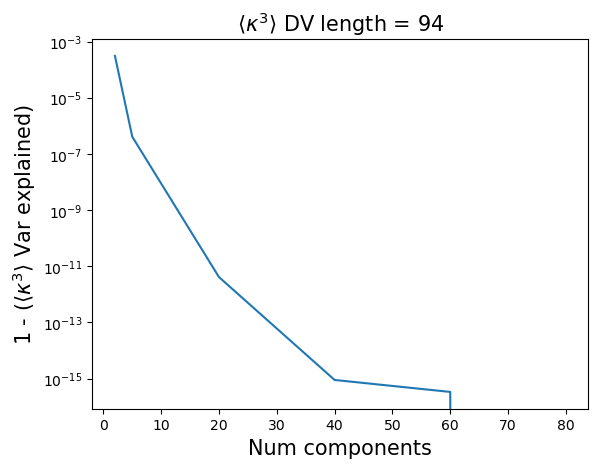

In [22]:
# exp_var_kp2
# pca_kp2.explained_variance_
# snr_kp2_orig_all
pl.figure()
pl.plot(var_th_all_kp3, exp_var_kp3)
pl.yscale('log')
# pl.plot(var_th_all_kp2, snr_kp2_pca_all)
pl.ylabel(r'1 - ($\langle \kappa^3 \rangle$ Var explained)', size=15)
pl.xlabel(r'Num components', size=15)
pl.title(r'$\langle \kappa^3 \rangle$ DV length = ' + str(), size=15)
pl.show()




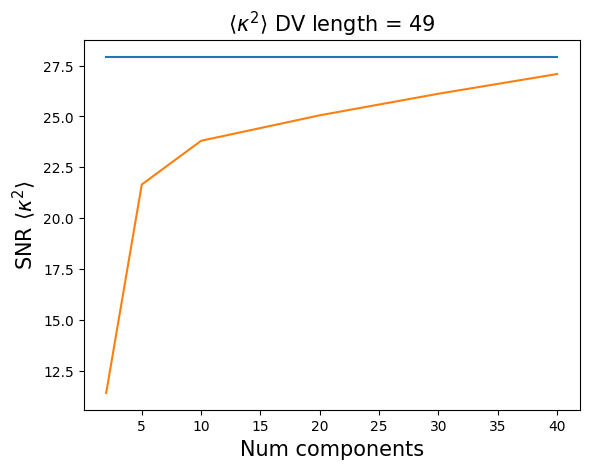

In [15]:
# snr_kp2_orig_all
pl.figure()
pl.plot(var_th_all_kp2, snr_kp2_orig_all)
pl.plot(var_th_all_kp2, snr_kp2_pca_all)
pl.ylabel(r'SNR $\langle \kappa^2 \rangle$', size=15)
pl.xlabel(r'Num components', size=15)
pl.title(r'$\langle \kappa^2 \rangle$ DV length = ' + str(dv_length_kp2), size=15)
pl.show()




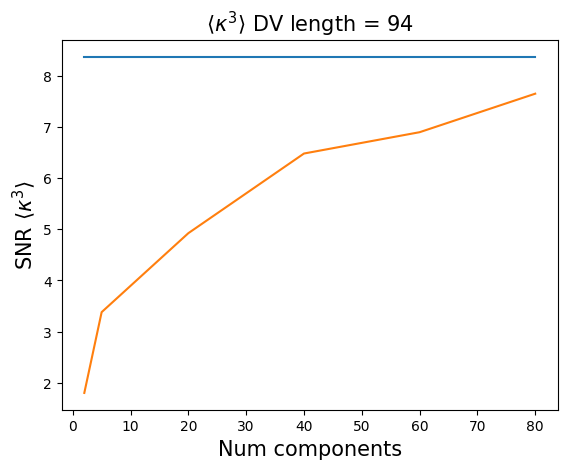

In [16]:
# snr_kp2_orig_all
pl.figure()
pl.plot(var_th_all_kp3, snr_kp3_orig_all)
pl.plot(var_th_all_kp3, snr_kp3_pca_all)
pl.ylabel(r'SNR $\langle \kappa^3 \rangle$', size=15)
pl.xlabel(r'Num components', size=15)
pl.title(r'$\langle \kappa^3 \rangle$ DV length = ' + str(dv_length_kp3), size=15)
pl.show()




In [10]:
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
# from sklearn.decomposition import KernelPCA

# var_th_all = [0.9999, 10, 25, 50, 100]
# var_th_all = [0.9999, 2,4,6]
# var_th_all = [2,4,6,8]
# var_th_all = [2,3,4,5,6,7,8]

# var_th_all_kp2 = [5,10,20,30,40]
# var_th_all_kp3 = [5,20,40,60,80]

var_th_all_kp2 = [2,5,10,20,30]
var_th_all_kp3 = [2,5,20,40,60]


# var_th_all_kp2 = [5,20,40,80,120]
# var_th_all_kp3 = [5,40,80,120,240]

snr_kp2_orig_all = np.zeros(len(var_th_all_kp2))
snr_kp3_orig_all = np.zeros(len(var_th_all_kp2))
snr_kp2_pca_all = np.zeros(len(var_th_all_kp2))
snr_kp3_pca_all = np.zeros(len(var_th_all_kp2))
exp_var_kp2 = np.zeros(len(var_th_all_kp2))
exp_var_kp3 = np.zeros(len(var_th_all_kp3))

for jv in tqdm(range(len(var_th_all_kp2))):
    var_th = var_th_all_kp2[jv]

    ica_kp2 = FastICA(n_components=int(0.8*dv_length_kp2),whiten=do_whiten, max_iter=400)    
    ica_kp2.fit(kp2_all_lhs_normalised)
    kp2_all_lhs_normalised_icaonly = ica_kp2.transform(kp2_all_lhs_normalised)
    pca_kp2 = PCA(n_components=var_th,whiten=do_whiten)
    pca_kp2.fit(kp2_all_lhs_normalised_icaonly)
    kp2_all_lhs_normalised_pcaonly = pca_kp2.transform(kp2_all_lhs_normalised_icaonly)
    var_th = var_th_all_kp3[jv]    
    
    ica_kp3 = FastICA(n_components=int(0.8*dv_length_kp3),whiten=do_whiten, max_iter=400)    
    ica_kp3.fit(kp3_all_lhs_normalised)
    kp3_all_lhs_normalised_icaonly = ica_kp3.transform(kp3_all_lhs_normalised)    
    pca_kp3 = PCA(n_components=var_th,whiten=do_whiten)
    # pca_kp3 = FastICA(n_components=var_th,whiten=do_whiten, max_iter=400)    
    # pca_kp3 = KernelPCA(n_components=var_th)        
    pca_kp3.fit(kp3_all_lhs_normalised_icaonly)
    kp3_all_lhs_normalised_pcaonly = pca_kp3.transform(kp3_all_lhs_normalised_icaonly)
    # print((pca_kp3.components_).shape)
    # from sklearn.decomposition import PCA
    var_th = var_th_all_kp2[jv]    
    
    pca_kp2_kp3 = PCA(n_components=var_th,whiten=do_whiten)
    # pca_kp2_kp3 = FastICA(n_components=var_th,whiten=do_whiten)    
    # pca_kp2_kp3 = KernelPCA(n_components=var_th)        
    pca_kp2_kp3.fit(kp2_kp3_all_lhs_normalised)
    kp2_kp3_all_lhs_normalised_pcaonly = pca_kp2_kp3.transform(kp2_kp3_all_lhs_normalised)


    kp2_all_data_normalised = scaler_kp2.transform(kp2_all_data[:,ind_filter_kp2])
    kp3_all_data_normalised = scaler_kp3.transform(kp3_all_data[:,ind_filter_kp3])
    kp2_kp3_all_data_normalised = scaler_kp2_kp3.transform(kp2_kp3_all_data[:,ind_filter_kp2_kp3])

    kp2_fid_normalised = scaler_kp2.transform(np.array([kp2_all_fid[ind_filter_kp2]]))
    kp3_fid_normalised = scaler_kp3.transform(np.array([kp3_all_fid[ind_filter_kp3]]))
    kp2_kp3_fid_normalised = scaler_kp2_kp3.transform(np.array([kp2_kp3_all_fid[ind_filter_kp2_kp3]]))

    kp2_sim_mean_normalised = scaler_kp2.transform(np.array([mean_kp2sims[ind_filter_kp2]]))
    kp3_sim_mean_normalised = scaler_kp3.transform(np.array([mean_kp3sims[ind_filter_kp3]]))
    kp2_kp3_sim_mean_normalised = scaler_kp2_kp3.transform(np.array([mean_kp2kp3sims[ind_filter_kp2_kp3]]))


    kp2_zeros_normalised = scaler_kp2.transform(np.array([np.zeros_like(ind_filter_kp2)]))
    kp3_zeros_normalised = scaler_kp3.transform(np.array([np.zeros_like(ind_filter_kp3)]))
    kp2_kp3_zeros_normalised = scaler_kp2_kp3.transform(np.array([np.zeros_like(ind_filter_kp2_kp3)]))

    
    kp2_all_data_normalised_icaonly = ica_kp2.transform(kp2_all_data_normalised)
    kp3_all_data_normalised_icaonly = ica_kp3.transform(kp3_all_data_normalised)
    kp2_all_data_normalised_pcaonly = pca_kp2.transform(kp2_all_data_normalised_icaonly)
    kp3_all_data_normalised_pcaonly = pca_kp3.transform(kp3_all_data_normalised_icaonly)
    
    kp2_kp3_all_data_normalised_pcaonly = pca_kp2_kp3.transform(kp2_kp3_all_data_normalised)

    
    
    kp2_fid_normalised_icaonly = ica_kp2.transform(kp2_fid_normalised)
    kp3_fid_normalised_icaonly = ica_kp3.transform(kp3_fid_normalised)
    kp2_fid_normalised_pcaonly = pca_kp2.transform(kp2_fid_normalised_icaonly)
    kp3_fid_normalised_pcaonly = pca_kp3.transform(kp3_fid_normalised_icaonly)
    
    kp2_kp3_fid_normalised_pcaonly = pca_kp2_kp3.transform(kp2_kp3_fid_normalised)

    kp2_sim_mean_normalised_icaonly = ica_kp2.transform(kp2_sim_mean_normalised)
    kp3_sim_mean_normalised_icaonly = ica_kp3.transform(kp3_sim_mean_normalised)
    kp2_sim_mean_normalised_pcaonly = pca_kp2.transform(kp2_sim_mean_normalised_icaonly)
    kp3_sim_mean_normalised_pcaonly = pca_kp3.transform(kp3_sim_mean_normalised_icaonly)
    
    kp2_kp3_sim_mean_normalised_pcaonly = pca_kp2_kp3.transform(kp2_kp3_sim_mean_normalised)

    
    kp2_zeros_normalised_icaonly = ica_kp2.transform(kp2_zeros_normalised)
    kp3_zeros_normalised_icaonly = ica_kp3.transform(kp3_zeros_normalised)
    kp2_zeros_normalised_pcaonly = pca_kp2.transform(kp2_zeros_normalised_icaonly)
    kp3_zeros_normalised_pcaonly = pca_kp3.transform(kp3_zeros_normalised_icaonly)
    
    kp2_kp3_zeros_normalised_pcaonly = pca_kp2_kp3.transform(kp2_kp3_zeros_normalised)
    
    # exp_var_kp2[jv] = 1-np.sum(pca_kp2.explained_variance_ratio_)
    # exp_var_kp3[jv] = 1-np.sum(pca_kp3.explained_variance_ratio_)    

    mean_kp2sims_pca = np.mean(kp2_all_data_normalised_pcaonly.T, axis=1)
    mean_kp3sims_pca = np.mean(kp3_all_data_normalised_pcaonly.T, axis=1)
    mean_kp2kp3sims_pca = np.mean(kp2_kp3_all_data_normalised_pcaonly.T, axis=1)

    cov_mat_kp2sims_pca = np.cov(kp2_all_data_normalised_pcaonly.T)
    cov_mat_kp3sims_pca = np.cov(kp3_all_data_normalised_pcaonly.T)
    cov_mat_kp2kp3sims_pca = np.cov(kp2_kp3_all_data_normalised_pcaonly.T)

    cov_mat_kp2sims = np.cov(kp2_all_data[:,ind_filter_kp2].T)
    snr_kp2_orig = np.sqrt(np.matmul(mean_kp2sims[ind_filter_kp2],np.matmul(np.linalg.inv(cov_mat_kp2sims), mean_kp2sims[ind_filter_kp2].T)))
    snr_kp2_orig_all[jv] = snr_kp2_orig

    delta_kp2 = mean_kp2sims_pca - kp2_zeros_normalised_pcaonly
    snr_kp2_pca = np.sqrt(np.matmul(delta_kp2,np.matmul(np.linalg.inv(cov_mat_kp2sims_pca), delta_kp2.T)))
    snr_kp2_pca_all[jv] = snr_kp2_pca

    if jv == 0:
        if len(ind_filter_kp3) < 700:
            cov_mat_kp3sims = np.cov(kp3_all_data[:,ind_filter_kp3].T)
            snr_kp3_orig = np.sqrt(np.matmul(mean_kp3sims[ind_filter_kp3],np.matmul(np.linalg.inv(cov_mat_kp3sims), mean_kp3sims[ind_filter_kp3].T)))
        else:
            snr_kp3_orig = -1.0
    snr_kp3_orig_all[jv] = snr_kp3_orig


    delta_kp3 = mean_kp3sims_pca - kp3_zeros_normalised_pcaonly
    snr_kp3_pca = np.sqrt(np.matmul(delta_kp3,np.matmul(np.linalg.inv(cov_mat_kp3sims_pca), delta_kp3.T)))
    snr_kp3_pca_all[jv] = snr_kp3_pca






 83%|████████▎ | 5/6 [00:21<00:04,  4.26s/it]


ValueError: n_components=40 must be between 0 and min(n_samples, n_features)=39 with svd_solver='full'

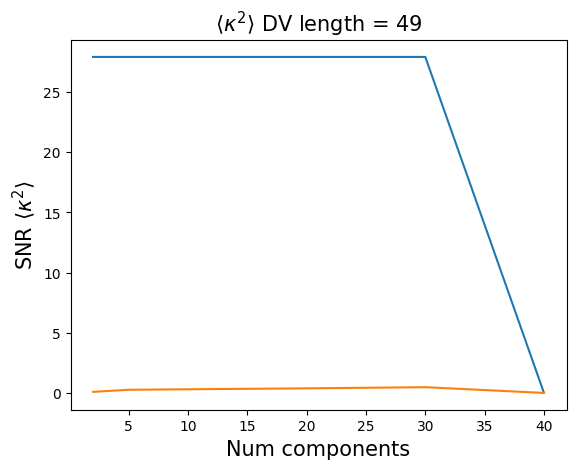

In [11]:
# snr_kp2_orig_all
pl.figure()
pl.plot(var_th_all_kp2, snr_kp2_orig_all)
pl.plot(var_th_all_kp2, snr_kp2_pca_all)
pl.ylabel(r'SNR $\langle \kappa^2 \rangle$', size=15)
pl.xlabel(r'Num components', size=15)
pl.title(r'$\langle \kappa^2 \rangle$ DV length = ' + str(dv_length_kp2), size=15)
pl.show()




In [16]:
# snr_kp3_orig_all
# snr_kp3_pca_all
cov_mat_kp3sims = np.cov(kp3_all_data[:,ind_filter_kp3].T)
np.sqrt(np.matmul(mean_kp3sims[ind_filter_kp3],np.matmul(np.linalg.inv(cov_mat_kp3sims), mean_kp3sims[ind_filter_kp3].T)))



1.8775226245582834

In [10]:
# %pip install scipy --upgrade
# ind_filter_kp3
# (mean_kp2sims_pca - kp2_sim_mean_normalised_pcaonly)/kp2_sim_mean_normalised_pcaonly


In [315]:
# (mean_kp3sims_pca - kp3_sim_mean_normalised_pcaonly)/kp3_sim_mean_normalised_pcaonly
# 
# kp3_sim_mean_normalised_pcaonly
mean_kp3sims_pca, kp3_sim_mean_normalised_pcaonly


(array([-5.19433532e-01, -3.21647260e-01,  8.06760009e-01, -1.36518390e-01,
        -4.71316026e-01, -5.22973853e-01,  1.78240167e-01, -6.71282522e-01,
         3.18910955e-01, -2.59563537e-01,  5.21474045e-02, -1.95128533e-01,
         1.24163636e-02,  3.11959156e-01, -2.62073214e-01,  1.11682828e+00,
        -2.04886409e-01,  9.79896456e-01, -1.43584823e+00, -8.05011051e-01,
         2.88571158e+00,  4.97750867e+00, -6.21574518e+00, -5.22594952e+00,
        -6.80841025e+00,  1.16055017e+01, -7.18366757e+00, -3.37212137e+00,
         4.54264934e+00,  1.45558599e+01,  8.41240539e+00,  1.75870979e+01,
        -2.83349383e+01,  6.12257955e+00, -1.13178014e+01, -4.00211243e+01,
         5.07085348e+01, -1.66574881e+00, -2.39513469e+01, -6.17409923e+00,
        -1.08231481e+01, -4.06190222e-03,  1.82880429e+01,  3.10484677e+01,
        -4.59108801e+01, -2.19621734e+01,  5.15023213e+01, -3.46272941e+01,
        -8.22825981e+01, -1.80662724e+02,  1.05642405e+01,  8.48392820e+01,
         5.6

/global/u1/s/spandey/self_module_ini/myenv3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until


nan

array([[30.62106889]])

KeyboardInterrupt: 

array([[9.56463245]])

In [ ]:
# cov_mat_kp2sims
# mean_kp2sims
# np.linalg.cond(cov_mat_kp2sims)




In [ ]:
import dill
saved = {'mean_kp2sims_pca':mean_kp2sims_pca, 'mean_kp3sims_pca':mean_kp3sims_pca, 'mean_kp2kp3sims_pca':mean_kp2kp3sims_pca,
        'cov_mat_kp2sims_pca':cov_mat_kp2sims_pca, 'cov_mat_kp3sims_pca':cov_mat_kp3sims_pca, 'cov_mat_kp2kp3sims_pca':cov_mat_kp2kp3sims_pca,
        'kp2_fid_normalised_pcaonly':kp2_fid_normalised_pcaonly, 'kp3_fid_normalised_pcaonly':kp3_fid_normalised_pcaonly, 
        'kp2_kp3_fid_normalised_pcaonly':kp2_kp3_fid_normalised_pcaonly, 'scaler_kp2':scaler_kp2,
        'scaler_kp3':scaler_kp3, 'scaler_kp2_kp3':scaler_kp2_kp3, 'pca_kp2':pca_kp2, 'pca_kp3':pca_kp3,
        'pca_kp2_kp3':pca_kp2_kp3, 'ind_filter_kp2':ind_filter_kp2, 'ind_filter_kp3':ind_filter_kp3,
        'ind_filter_kp2_kp3':ind_filter_kp2_kp3}
# dill.dump(saved, open('measurements_all.pk','wb'))
dill.dump(saved, open('measurements_OmAsonly_all_ncomp60.pk','wb'))
# dill.dump(saved, open('measurements_all_gtsc.pk','wb'))
# dill.dump(saved, open('measurements_auto_smbin_gtsc.pk','wb'))




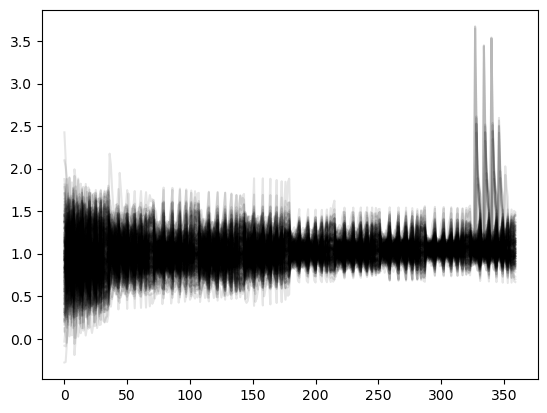

In [30]:
pl.figure()
for ji in range(kp2_all_data.shape[0]):
    pl.plot(kp2_all_data[ji,ind_filter_kp2]/kp2_all_fid[ind_filter_kp2], color='k', alpha=0.1)
pl.show()



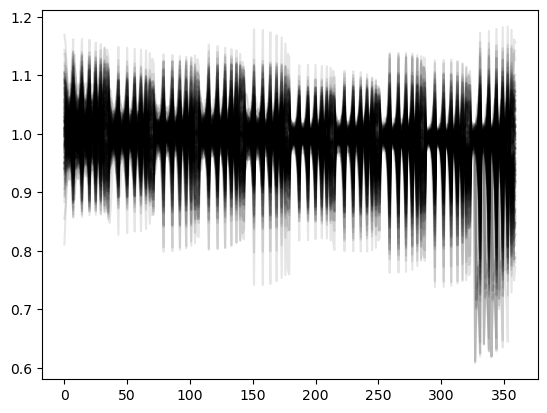

In [31]:
pl.figure()
for ji in range(kp2_all_data_normalised.shape[0]):
    pl.plot((kp2_all_data_normalised[ji,:]/kp2_fid_normalised)[0,:], color='k', alpha=0.1)
    # print(kp2_all_data_normalised[ji,:]/kp2_fid_normalised)
pl.show()



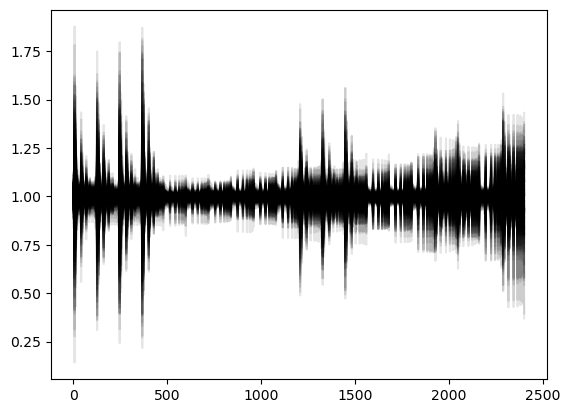

In [44]:
pl.figure()
for ji in range(kp3_all_data_normalised.shape[0]):
    pl.plot((kp3_all_data_normalised[ji,:]/kp3_fid_normalised)[0,:], color='k', alpha=0.1)
    # print(kp2_all_data_normalised[ji,:]/kp2_fid_normalised)
pl.show()



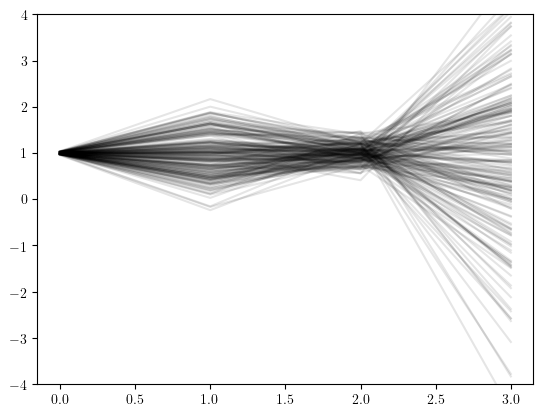

In [82]:
pl.figure()
for ji in range(kp3_all_data_normalised.shape[0]):
    pl.plot((kp3_all_data_normalised_pcaonly[ji,:]/kp3_fid_normalised_pcaonly)[0,:], color='k', alpha=0.1)
    # pl.plot((kp3_all_data_normalised_pcaonly[ji,:]/mean_kp3sims_pca), color='k', alpha=0.1)
    # print(kp2_all_data_normalised[ji,:]/kp2_fid_normalised)
pl.ylim(-4,4)
pl.show()



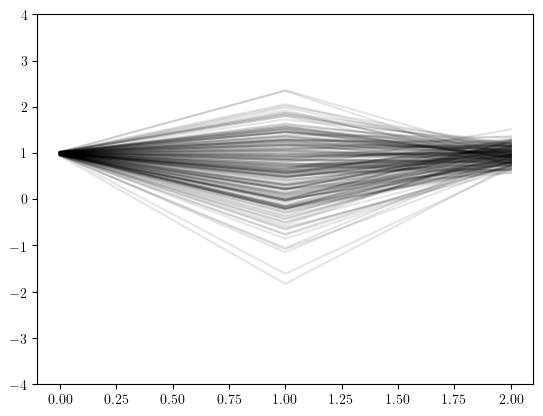

In [83]:
pl.figure()
for ji in range(kp2_all_data_normalised.shape[0]):
    pl.plot((kp2_all_data_normalised_pcaonly[ji,:]/kp2_fid_normalised_pcaonly)[0,:], color='k', alpha=0.1)
    # pl.plot((kp3_all_data_normalised_pcaonly[ji,:]/mean_kp3sims_pca), color='k', alpha=0.1)
    # print(kp2_all_data_normalised[ji,:]/kp2_fid_normalised)
pl.ylim(-4,4)
pl.show()



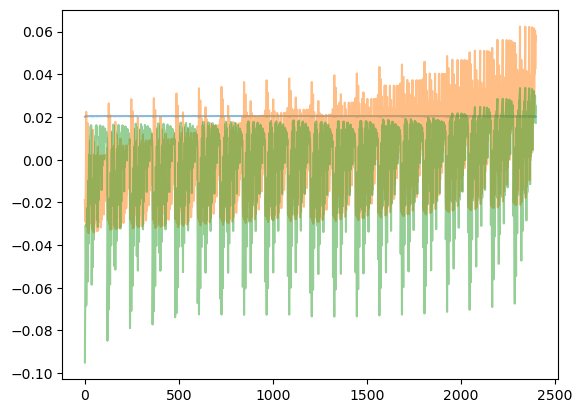

In [33]:
# pca_kp2.components_
pl.figure()
for ji in range(pca_kp2.components_.shape[0]):
    # pl.plot((pca_kp2.components_[ji,:]), color='k', alpha=0.1)
    # pl.plot((pca_kp2.components_[ji,:]), color='k', alpha=0.1)    
    pl.plot((pca_kp3.components_[ji,:]), alpha=0.5)    
    # print(kp2_all_data_normalised[ji,:]/kp2_fid_normalised)
pl.show()






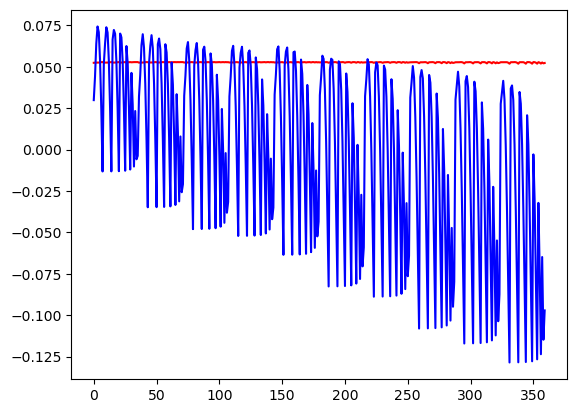

In [34]:
# pca_kp2.components_
import seaborn as sns   

num_lines = 2

ax = pl.subplot(111)
# ax.set_prop_cycle(color=sns.color_palette("coolwarm_r",num_lines))
# pl.figure()
# for ji in range(pca_kp3.components_.shape[0]):
colors = ['r','b','k','orange', 'cyan']
for ji in range(num_lines):    
    ax.plot((pca_kp2.components_[ji,:]),  alpha=1.0, color=colors[ji])
    # pl.plot((pca_kp3.components_[ji,:]), color=colors[ji], alpha=1.0)    
    # print(kp2_all_data_normalised[ji,:]/kp2_fid_normalised)
pl.show()





In [81]:
# pca_kp3.components_.shape
# pca_kp3.components_[0,:]



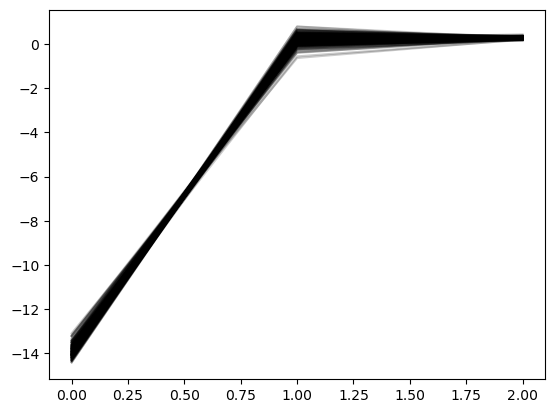

In [36]:
# scaler_kp2_kp3 = StandardScaler().fit(kp2_kp3_all_lhs)
# kp2_kp3_all_lhs_normalised = scaler_kp2_kp3.transform(kp2_kp3_all_lhs)
pl.figure()
for ji in range(kp2_all_data_normalised_pcaonly.shape[0]):
    pl.plot(kp2_all_data_normalised_pcaonly[ji,:], color='k', alpha=0.2)
pl.show()




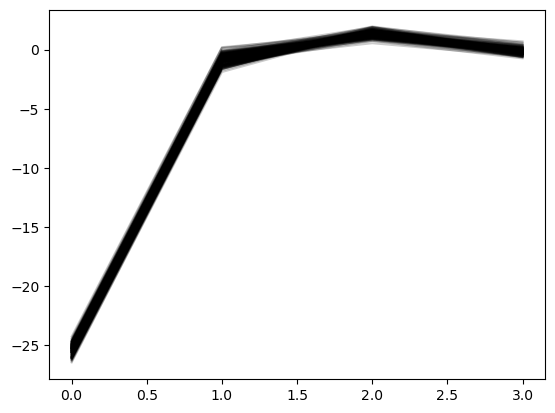

In [37]:
# scaler_kp2_kp3 = StandardScaler().fit(kp2_kp3_all_lhs)
# kp2_kp3_all_lhs_normalised = scaler_kp2_kp3.transform(kp2_kp3_all_lhs)
pl.figure()
for ji in range(kp3_all_data_normalised_pcaonly.shape[0]):
    pl.plot(kp3_all_data_normalised_pcaonly[ji,:], color='k', alpha=0.2)
pl.show()




In [73]:
# mean_kp2sims_pca
# kp2_all_data_normalised_pcaonly.shape
# mean_kp2sims_pca, kp2_fid_normalised_pcaonly
# mean_kp3sims_pca, kp3_fid_normalised_pcaonly
mean_kp2sims_pca, np.sqrt(np.diag(cov_mat_kp2sims_pca))



(array([-4.40959841,  1.35448876, -0.77313709,  0.32175476,  0.16426545,
         0.01115216,  0.03025774, -0.10675878,  0.01725452,  0.11614741,
         0.0100163 ,  0.01988856,  0.05333137, -0.01869072]),
 array([0.03874591, 0.02813421, 0.00668843, 0.03965256, 0.0169114 ,
        0.01322911, 0.02307066, 0.01564293, 0.01918129, 0.02646783,
        0.00630197, 0.01805718, 0.00725002, 0.0133136 ]))

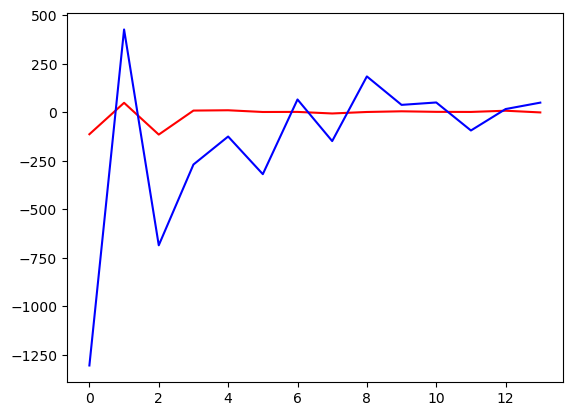

In [74]:
# pl.figure()
# pl.imshow(np.log(np.abs(cov_mat_kp2sims_pca)))
# pl.colorbar()
# pl.show()
pl.figure()
pl.plot(mean_kp2sims_pca/(np.sqrt(np.diag(cov_mat_kp2sims_pca))), color='r')
pl.plot(mean_kp3sims_pca/(np.sqrt(np.diag(cov_mat_kp3sims_pca))), color='b')
# pl.colorbar()
pl.show()




In [87]:
# pl.figure()
# pl.imshow(np.log(np.abs(cov_mat_kp2sims_pca)))
# pl.colorbar()
# pl.show()
# pl.figure()
# pl.plot(, color='r')
# pl.plot(mean_kp3sims_pca/(np.sqrt(np.diag(cov_mat_kp3sims_pca))), color='b')
# pl.colorbar()
# pl.show()




In [48]:
cov_mat_kp2sims_pca = np.cov(kp2_all_data_normalised.T)
np.sqrt(np.matmul(kp2_fid_normalised,np.matmul(np.linalg.inv(cov_mat_kp2sims_pca), kp2_fid_normalised.T)))




array([[33.69910983]])

In [41]:
np.sqrt(np.matmul(mean_kp2sims_pca,np.matmul(np.linalg.inv(cov_mat_kp2sims_pca), mean_kp2sims_pca.T)))




773.0701688670899

In [42]:
# cov_mat_kp2sims_pca.shape
# mean_kp2sims_pca.shape
# np.linalg.inv(cov_mat_kp2sims_pca)
# np.matmul(np.linalg.inv(cov_mat_kp2sims_pca), mean_kp2sims_pca.T)



In [43]:
np.sqrt(np.matmul(mean_kp3sims_pca,np.matmul(np.linalg.inv(cov_mat_kp3sims_pca), mean_kp3sims_pca.T)))



4189.689813277208

In [78]:
# cov_mat_kp3sims_pca
np.log(np.abs(cov_mat_kp3sims_pca))


array([[-9.4053909 , -6.61190456, -7.26840563, -6.95051637],
       [-6.61190456, -3.65968989, -4.9256515 , -3.58470692],
       [-7.26840563, -4.9256515 , -3.70890601, -4.39265085],
       [-6.95051637, -3.58470692, -4.39265085, -2.80992048]])

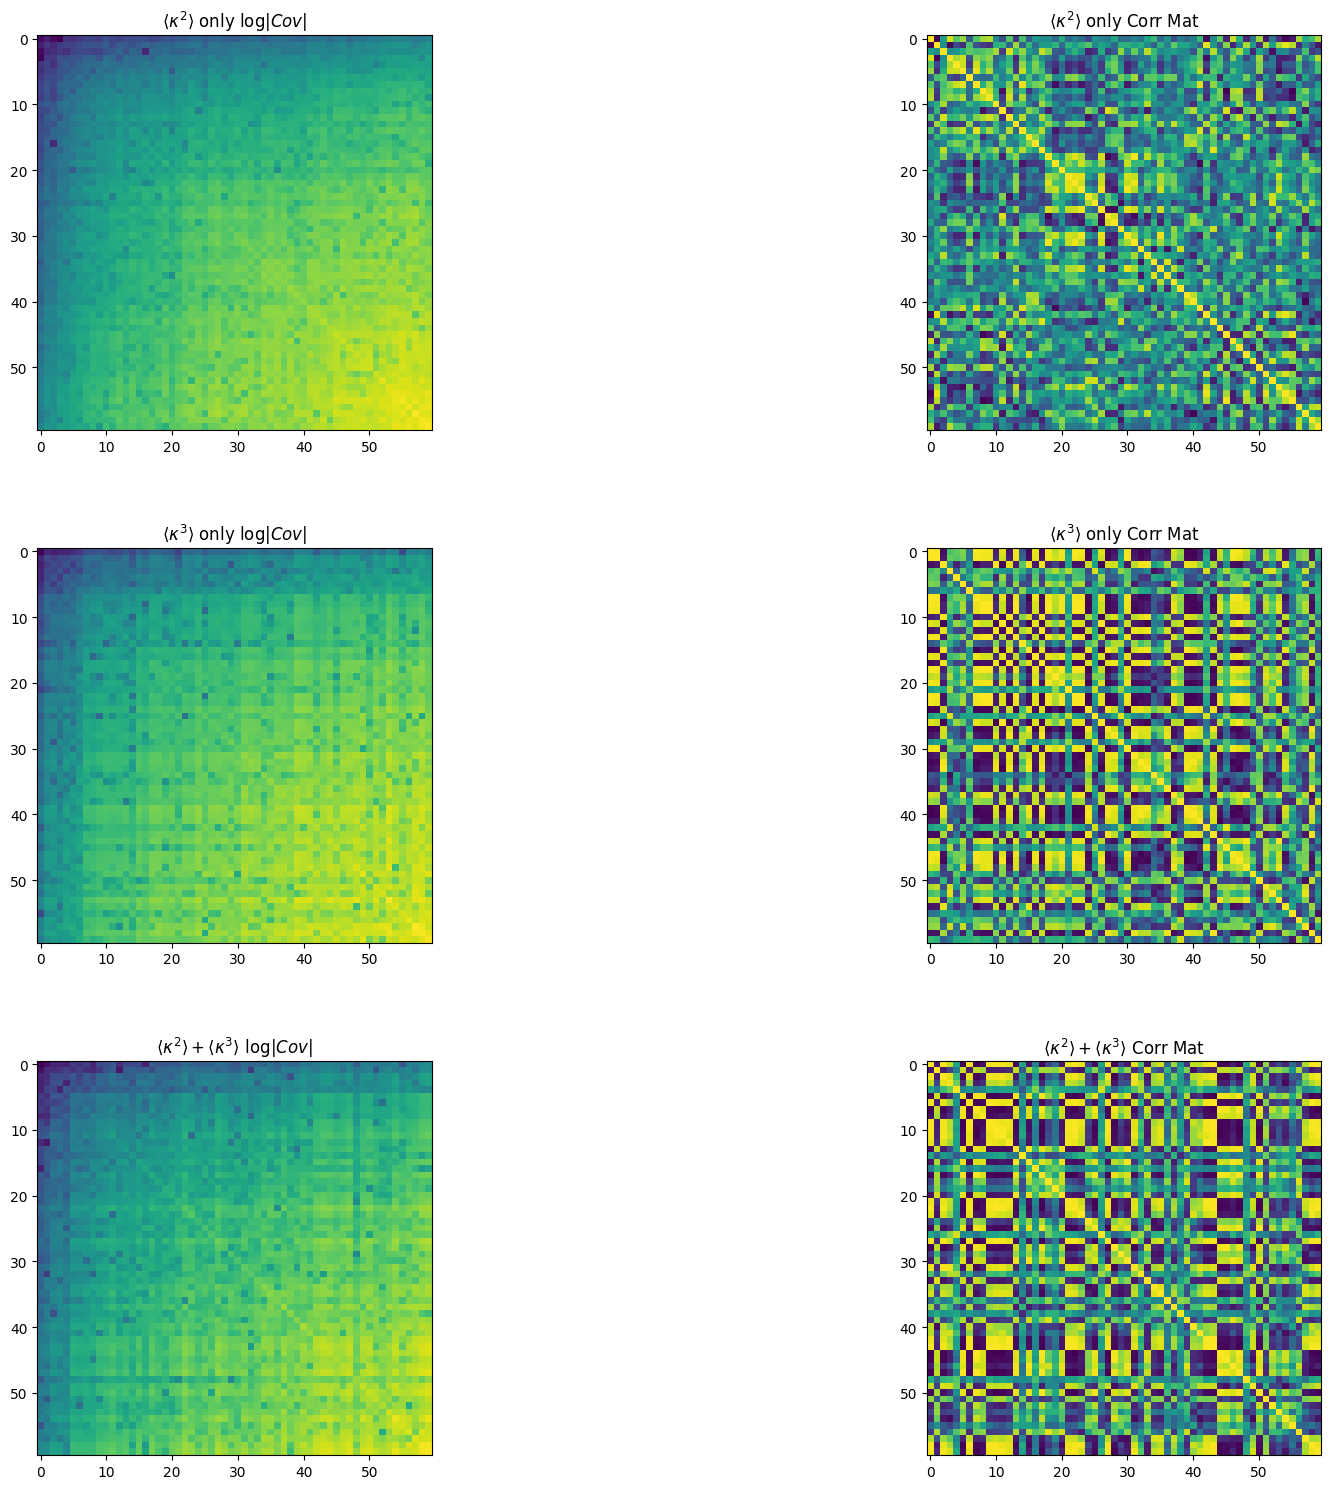

In [321]:
fig, ax_all2 = pl.subplots(3,2,figsize=(18,15))
for jv in range(3):
    ax_all = ax_all2[jv]
    for jp in range(2):
        ax = ax_all[jp]
        if jp == 0:
            if jv == 1:
                ax.imshow(np.log(np.abs(cov_mat_kp3sims_pca)))
                ax.set_title(r'$\langle \kappa^3 \rangle$ only $\log{|Cov|}$')
            if jv == 0:
                ax.imshow(np.log(np.abs(cov_mat_kp2sims_pca)))
                ax.set_title(r'$\langle \kappa^2 \rangle$ only $\log{|Cov|}$')
            if jv == 2:
                ax.imshow(np.log(np.abs(cov_mat_kp2kp3sims_pca)))
                ax.set_title(r'$\langle \kappa^2 \rangle + \langle \kappa^3 \rangle$ $\log{|Cov|}$')
                
                
        if jp == 1:
            if jv == 1:
                ax.imshow((np.corrcoef((cov_mat_kp3sims_pca))))
                ax.set_title(r'$\langle \kappa^3 \rangle$ only Corr Mat')
            if jv == 0:
                ax.imshow((np.corrcoef((cov_mat_kp2sims_pca))))
                ax.set_title(r'$\langle \kappa^2 \rangle$ only Corr Mat')
            if jv == 2:
                ax.imshow((np.corrcoef((cov_mat_kp2kp3sims_pca))))
                ax.set_title(r'$\langle \kappa^2 \rangle + \langle \kappa^3 \rangle$ Corr Mat')
                
            
fig.tight_layout()
fig.subplots_adjust(hspace=0.3, wspace=0.01)
# fig.savefig('test_cov_corrmat_auto_smbin_gtsc.pdf')
# fig.savefig('test_cov_corrmat_all_gtsc.pdf')
pl.show()
       

    

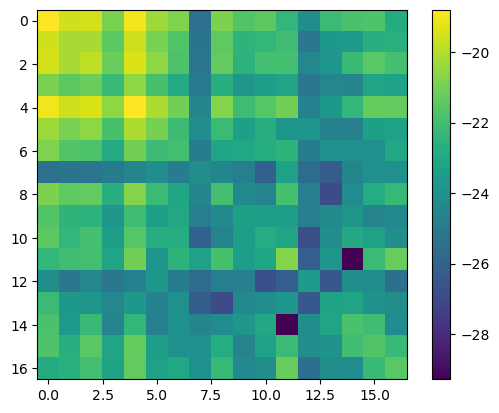

In [52]:
pl.figure()
pl.imshow(np.log(np.abs(cov_mat_kp3sims_pca)))
pl.colorbar()
pl.show()



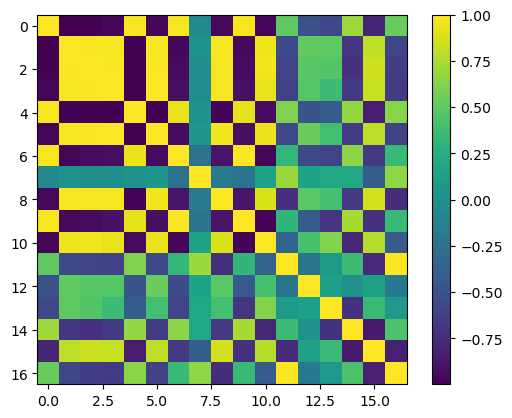

In [53]:
pl.figure()
pl.imshow((np.corrcoef((cov_mat_kp3sims_pca))))
pl.colorbar()
pl.show()



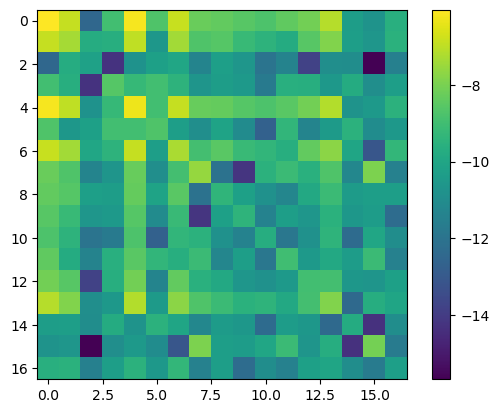

In [54]:
pl.figure()
pl.imshow(np.log(np.abs(cov_mat_kp2sims_pca)))
pl.colorbar()
pl.show()



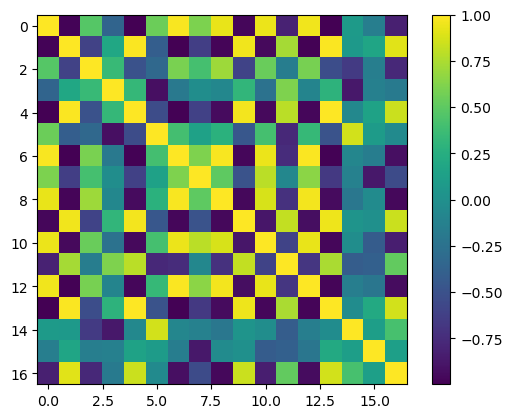

In [55]:
pl.figure()
pl.imshow(np.corrcoef((cov_mat_kp2sims_pca)))
pl.colorbar()
pl.show()



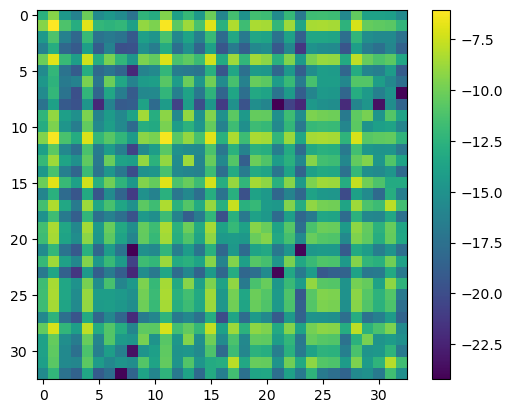

In [56]:
pl.figure()
pl.imshow(np.log(np.abs(cov_mat_kp2kp3sims_pca)))
pl.colorbar()
pl.show()



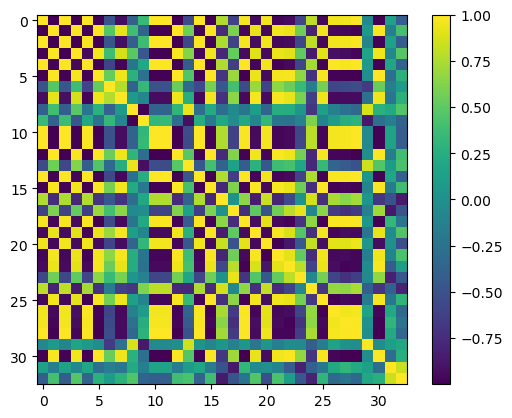

In [57]:
pl.figure()
pl.imshow(np.corrcoef((cov_mat_kp2kp3sims_pca)))
pl.colorbar()
pl.show()



In [ ]:
# '/global/cfs/cdirs/des/shivamp/cosmosis2p0/cosmosis-standard-library/output/GM_chains/test_kp2kp3_autosm_gtsc.txt'



In [1]:
import matplotlib
from getdist import plots, MCSamples
import numpy as np
import matplotlib.pyplot as pl
import matplotlib
import pdb
import scipy.optimize as op
import scipy.special as spsp
from getdist.paramnames import escapeLatex, makeList, mergeRenames
import matplotlib
# matplotlib.rcParams['text.usetex'] = False
matplotlib.rcParams['text.usetex'] = True
# matplotlib.rcParams['text.latex.unicode'] = True
import getdist



In [2]:
def get_nsample(filename):
    with open(filename,"r") as fi:
        for ln in fi:
            if ln.startswith("#nsample="):
                nsamples = int(ln[9:])
    return nsamples

def get_evidence(filename):
    with open(filename,"r") as fi:
        for ln in fi:
            if ln.startswith("#log_z="):
                logz = float(ln[7:])
    return logz


def get_param_names(filename):
    with open(filename,"r") as fi:
        param_names = np.array((fi.readline()[1:].split()))
    return param_names


def get_S8(data, names, Omega_m_name = 'cosmological_parameters--omega_m', sigma_8_name = 'COSMOLOGICAL_PARAMETERS--SIGMA_8', alpha=0.5):
    output_names = []
    ind_data = []
    for ii in range(len(names)):
        if (names[ii] in [Omega_m_name]):
            Omega_m_ind = ii
        if (names[ii] in [sigma_8_name]):
            sig8_ind = ii
    sigma_8 = data[:,sig8_ind]
    omega_m = data[:,Omega_m_ind]
    s8 = sigma_8 * (omega_m/0.3)**alpha
    return s8

def get_Obh2(data, names, Omega_b_name = 'cosmological_parameters--omega_b', h_name = 'cosmological_parameters--h0'):
    output_names = []
    ind_data = []
    for ii in range(len(names)):
        if (names[ii] in [Omega_b_name]):
            Omega_b_ind = ii
        if (names[ii] in [h_name]):
            h_ind = ii
    h0 = data[:,h_ind]
    omega_b = data[:,Omega_b_ind]
    return omega_b * (h0**2)

def get_Omh3(data, names, Omega_m_name = 'cosmological_parameters--omega_m', h_name = 'cosmological_parameters--h0'):
    output_names = []
    ind_data = []
    for ii in range(len(names)):
        if (names[ii] in [Omega_m_name]):
            Omega_m_ind = ii
        if (names[ii] in [h_name]):
            h_ind = ii
    h0 = data[:,h_ind]
    omega_m = data[:,Omega_m_ind]
    return omega_m * (h0**3)


def extract_bi(data, names, b1_name = 'bias_lens--b1e_sig8_bin', b2_name = 'bias_lens--b2e_sig8sq_bin', b1_name_out = 'bias_lens--b1e_bin', b2_name_out = 'bias_lens--b2e_bin', sigma_8_name = 'COSMOLOGICAL_PARAMETERS--SIGMA_8',bins_fit = [1,2,3,4,5]):
    b1_all = {}
    b2_all = {}
    for ii in range(len(names)):
        if (names[ii] in [sigma_8_name]):
            sig8_ind = ii
    sigma_8 = data[:,sig8_ind]
    
    for bini in bins_fit:
        for ii in range(len(names)):
            if (names[ii] == b1_name + str(bini)):
                b1_i = data[:,ii]/sigma_8
                b1_all[b1_name_out + str(bini)] = b1_i
            
            if (names[ii] == b2_name + str(bini)):
                b2_i = data[:,ii]/(sigma_8**2)
                b2_all[b2_name_out + str(bini)] = b2_i
    
    return b1_all, b2_all


def get_max_2dpost(g, root, param1='cosmological_parameters--omega_m', param2='cosmological_parameters--s8',param_pair = None):
    param_pair = g.get_param_array(root, param_pair or [param1, param2])
    
    density = g.sample_analyser.get_density_grid(root, param_pair[0], param_pair[1],
                                                                conts=g.settings.num_plot_contours,
                                                                likes=g.settings.shade_meanlikes)
    xyind = np.where(density.P == np.amax(density.P))
    return density.y[xyind[0][0]],density.x[xyind[1][0]]
    
def get_contour_line(sigma_contour,g, density):

    contours = spsp.erf(sigma_contour/np.sqrt(2))
    density.contours = density.getContourLevels([contours])
    contour_levels = density.contours
    fig1, ax1 = pl.subplots(1)
    cs = pl.contour(density.x, density.y, density.P, sorted(contour_levels))
    lines = []
    for line in cs.collections[0].get_paths():
        lines.append(line.vertices)
    pl.close()
    return lines

def get_dmin(line, xref, yref):
    linex = line[0][:,0]
    liney = line[0][:,1]
    d_all = np.sqrt((linex - xref)**2 + (liney - yref)**2)
    dmin = np.amin(d_all)
    return dmin

def lefthand(sigma_contour, g, density, xref, yref): 
    line = get_contour_line(sigma_contour,g, density)
    result = get_dmin(line, xref, yref)  
    return result

lefthand = np.vectorize(lefthand)
   
def diff(sigma_contour, g, density, xref, yref):
    result = lefthand(sigma_contour, g, density, xref, yref)
    return result

def root_find(init_x,g, density, xref, yref): 
    nll = lambda *args: diff(*args)
    args = (g, density, xref, yref)
    result = op.root(nll,np.array([init_x]),args=args,options={'maxfev':50})
    return result

def min_find(init_x,g, density, xref, yref): 
    nll = lambda *args: diff(*args)
    args = (g, density, xref, yref)
    result = op.fmin(nll,np.array([init_x]),args=args)
    return result
 
def unit_vector(vector):
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))   

def get_frac_angle(start_coord, end_coord,xlims, ylims):
    xmean12 = (0.5*(start_coord[0] + end_coord[0]))
    ymean12 = (0.5*(start_coord[1] + end_coord[1]))
    dx = xlims[1] - xlims[0]
    dy = ylims[1] - ylims[0]
    dxp = xmean12 - end_coord[0]
    dyp = ymean12 - end_coord[1]
    angle_deg = 180.+ np.arctan2((end_coord[1]-start_coord[1])/dy,( end_coord[0]-start_coord[0])/dx)*(180./np.pi)
    return xmean12-dxp/2, ymean12+dyp/3, angle_deg

def replace_fancy(names, fancy_dic):
    output_names = []
    ind_data = []
    for ii in range(len(names)):
        if (names[ii] in fancy_dic):
            output_names.append(fancy_dic[names[ii]])
            ind_data.append(ii)
    return np.array(output_names), np.array(ind_data)



Removed no burn in
cosmological_parameters--omega_m: 0.2629212487825431, 0.037595351026925794, 0.0264293590392064
cosmological_parameters--s8: 0.7767373950797019, 0.020794688832459718, 0.023260201089264188
Removed no burn in
cosmological_parameters--omega_m: 0.2599740348404378, 0.033780073669628485, 0.026266237408081206
cosmological_parameters--s8: 0.7798881123374233, 0.019257464790005785, 0.018834250414510367


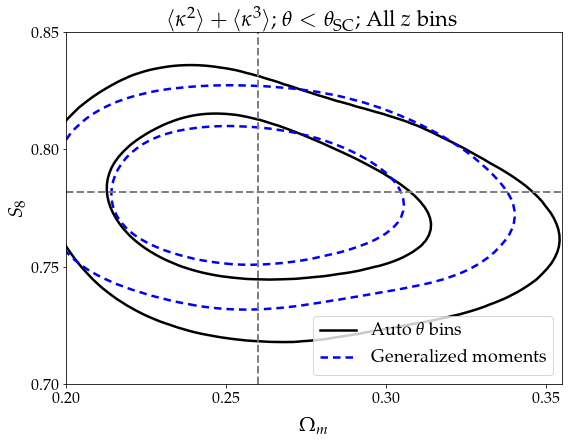

In [5]:
def replace_fancy(names, fancy_dic):
    output_names = []
    ind_data = []
    for ii in range(len(names)):
        if (names[ii] in fancy_dic):
            output_names.append(fancy_dic[names[ii]])
            ind_data.append(ii)
#         else:
#             output_names.append()
    return np.array(output_names), np.array(ind_data)


filename_list = [
    
    # '/global/cfs/cdirs/des/shivamp/cosmosis2p0/cosmosis-standard-library/output/GM_chains/kp2_kp3_OmAsonly_auto_smbin_ltsc_MOPED_inf15p.txt',      
    # '/global/cfs/cdirs/des/shivamp/cosmosis2p0/cosmosis-standard-library/output/GM_chains/kp2_kp3_OmAsonly_all_ltsc_MOPED_inf15p.txt',        
    '/global/cfs/cdirs/des/shivamp/cosmosis2p0/cosmosis-standard-library/output/GM_chains/kp2kp3_kp2kp3_allparams_auto_smbin_gtsc_MOPED_inf1p_cosmogrid.txt',      
    '/global/cfs/cdirs/des/shivamp/cosmosis2p0/cosmosis-standard-library/output/GM_chains/kp2kp3_allparams_all_gtsc_MOPED_inf1p_cosmogrid.txt'
    # '/global/cfs/cdirs/des/shivamp/cosmosis2p0/cosmosis-standard-library/output/GM_chains/kp2_kp3_OmAsonly_all_ltsc_MOPED_inf15p.txt',            

    # '/global/cfs/cdirs/des/shivamp/cosmosis2p0/cosmosis-standard-library/output/GM_chains/kp2_kp3_OmAsonly_auto_zbin_smbin_ltsc_MOPED_inf15p.txt',      
    # '/global/cfs/cdirs/des/shivamp/cosmosis2p0/cosmosis-standard-library/output/GM_chains/kp2_kp3_OmAsonly_auto_zbin_ltsc_MOPED_inf15p.txt',        
    
    
    # '/global/cfs/cdirs/des/shivamp/cosmosis2p0/cosmosis-standard-library/output/GM_chains/kp2_kp3_allparams_auto_smbin_gtsc_MOPED_inf15p.txt',      
    # '/global/cfs/cdirs/des/shivamp/cosmosis2p0/cosmosis-standard-library/output/GM_chains/kp2_kp3_allparams_all_gtsc_MOPED_inf15p.txt',        
    
    # '/global/cfs/cdirs/des/shivamp/cosmosis2p0/cosmosis-standard-library/output/GM_chains/kp2_allparams_auto_smbin_gtsc_MOPED_inf15p.txt',      
    # '/global/cfs/cdirs/des/shivamp/cosmosis2p0/cosmosis-standard-library/output/GM_chains/kp2_allparams_all_gtsc_MOPED_inf15p.txt',        

    # '/global/cfs/cdirs/des/shivamp/cosmosis2p0/cosmosis-standard-library/output/GM_chains/kp3_allparams_auto_smbin_gtsc_MOPED_inf15p.txt',      
    # '/global/cfs/cdirs/des/shivamp/cosmosis2p0/cosmosis-standard-library/output/GM_chains/kp3_allparams_all_gtsc_MOPED_inf15p.txt',        

    
    # '/global/cfs/cdirs/des/shivamp/cosmosis2p0/cosmosis-standard-library/output/GM_chains/kp2_allparams_auto_smbin_gtsc_MOPED_inf15p.txt',      
    # '/global/cfs/cdirs/des/shivamp/cosmosis2p0/cosmosis-standard-library/output/GM_chains/kp3_allparams_auto_smbin_gtsc_MOPED_inf15p.txt',          
    # '/global/cfs/cdirs/des/shivamp/cosmosis2p0/cosmosis-standard-library/output/GM_chains/kp2_kp3_allparams_auto_smbin_gtsc_MOPED_inf15p.txt',          

    
    # '/global/cfs/cdirs/des/shivamp/cosmosis2p0/cosmosis-standard-library/output/GM_chains/kp2_allparams_all_gtsc_MOPED_inf15p.txt',        
    # '/global/cfs/cdirs/des/shivamp/cosmosis2p0/cosmosis-standard-library/output/GM_chains/kp3_allparams_all_gtsc_MOPED_inf15p.txt',                
    # '/global/cfs/cdirs/des/shivamp/cosmosis2p0/cosmosis-standard-library/output/GM_chains/kp2_kp3_allparams_all_gtsc_MOPED_inf15p.txt',        
    
    
    
    # '/global/cfs/cdirs/des/shivamp/cosmosis2p0/cosmosis-standard-library/output/GM_chains/kp2_kp3_OmAsonly_auto_smbin_gtsc_MOPED_inf15p.txt',      
    # '/global/cfs/cdirs/des/shivamp/cosmosis2p0/cosmosis-standard-library/output/GM_chains/kp2_kp3_OmAsonly_all_gtsc_MOPED_inf15p.txt',        
    
    # '/global/cfs/cdirs/des/shivamp/cosmosis2p0/cosmosis-standard-library/output/GM_chains/kp2_OmAsonly_auto_smbin_gtsc_MOPED_inf15p.txt',      
    # '/global/cfs/cdirs/des/shivamp/cosmosis2p0/cosmosis-standard-library/output/GM_chains/kp2_OmAsonly_all_gtsc_MOPED_inf15p.txt',        

    # '/global/cfs/cdirs/des/shivamp/cosmosis2p0/cosmosis-standard-library/output/GM_chains/kp3_OmAsonly_auto_smbin_gtsc_MOPED_inf15p.txt',      
    # '/global/cfs/cdirs/des/shivamp/cosmosis2p0/cosmosis-standard-library/output/GM_chains/kp3_OmAsonly_all_gtsc_MOPED_inf15p.txt',        

    
    # '/global/cfs/cdirs/des/shivamp/cosmosis2p0/cosmosis-standard-library/output/GM_chains/kp2_OmAsonly_auto_smbin_gtsc_MOPED_inf15p.txt',      
    # '/global/cfs/cdirs/des/shivamp/cosmosis2p0/cosmosis-standard-library/output/GM_chains/kp3_OmAsonly_auto_smbin_gtsc_MOPED_inf15p.txt',          
    # '/global/cfs/cdirs/des/shivamp/cosmosis2p0/cosmosis-standard-library/output/GM_chains/kp2_kp3_OmAsonly_auto_smbin_gtsc_MOPED_inf15p.txt',          

    
    # '/global/cfs/cdirs/des/shivamp/cosmosis2p0/cosmosis-standard-library/output/GM_chains/kp2_OmAsonly_all_gtsc_MOPED_inf15p.txt',        
    # '/global/cfs/cdirs/des/shivamp/cosmosis2p0/cosmosis-standard-library/output/GM_chains/kp3_OmAsonly_all_gtsc_MOPED_inf15p.txt',                
    # '/global/cfs/cdirs/des/shivamp/cosmosis2p0/cosmosis-standard-library/output/GM_chains/kp2_kp3_OmAsonly_all_gtsc_MOPED_inf15p.txt',        
    
    
    # '/global/cfs/cdirs/des/shivamp/cosmosis2p0/cosmosis-standard-library/output/GM_chains/kp3_autosm_all.txt',            
    # '/global/cfs/cdirs/des/shivamp/cosmosis2p0/cosmosis-standard-library/output/GM_chains/kp3_all.txt',        
    
    
    # '/global/cfs/cdirs/des/shivamp/boss_cosmosis/cosmosis/y3-3x2pt/chains/chain_2x2_0321.txt',
    # '/global/cfs/cdirs/des/shivamp/boss_cosmosis/cosmosis/y3-3x2pt/chains/chain_2x2pt_NLbias86_lcdm.txt',
    # '/global/cfs/cdirs/des/shivamp/boss_cosmosis/cosmosis/y3-3x2pt/chains/chain_2x2pt_NLbias44_lcdm.txt',
]

# legend_labels = [r'Linear Bias, (8,6)Mpc/$h$',r'Non-Linear Bias, (8,6)Mpc/$h$',r'Non-Linear Bias, (4,4)Mpc/$h$','DES Y1, 2x2pt', 'Planck 2018']
legend_labels = [r'Auto $\theta$ bins', 'Generalized moments',r'Linear Bias, (8,6)Mpc/$h$',r'Non-Linear Bias, (8,6)Mpc/$h$',r'Non-Linear Bias, (4,4)Mpc/$h$']
# legend_labels = ['with scale cuts','All scales',r'Linear Bias, (8,6)Mpc/$h$',r'Non-Linear Bias, (8,6)Mpc/$h$',r'Non-Linear Bias, (4,4)Mpc/$h$']
# legend_labels = [r'$\langle \kappa^2 \rangle$ only',r'$\langle \kappa^3 \rangle$ only',r'$\langle \kappa^2 \rangle + \langle \kappa^3 \rangle$',r'Linear Bias, (8,6)Mpc/$h$',r'Non-Linear Bias, (8,6)Mpc/$h$',r'Non-Linear Bias, (4,4)Mpc/$h$']

ext_b1b2 = [0,0,0,0]

all_data = []
all_samples = []

# fancy_dictionary = {'cosmological_parameters--omega_m':r'$\Omega_m$','cosmological_parameters--omega_mcb':r'$\Omega_m - \Omega_{\nu}$','cosmological_parameters--s8':r'$S_8$','cosmological_parameters--omnuh2':r'$\Omega_{\nu} h^2$'}  
# fancy_dictionary = {'cosmological_parameters--omega_m':r'$\Omega_m$','cosmological_parameters--omega_mcb':r'$\Omega_m - \Omega_{\nu}$','cosmological_parameters--s8':r'$S_8$','cosmological_parameters--omnuh2':r'$\Omega_{\nu} h^2$'}  
fancy_dictionary = {'cosmological_parameters--omega_m':r'$\Omega_m$','cosmological_parameters--s8':r'$S_8$'} 
# fancy_dictionary = {'cosmological_parameters--omega_m':r'$\Omega_m$','COSMOLOGICAL_PARAMETERS--SIGMA_8':r'$\sigma_8$'} 
# fancy_dictionary = {'cosmological_parameters--omega_m':r'$\Omega_m$','cosmological_parameters--mnu':r'$m_{\nu}$'} 

for fi in range(0,len(filename_list)):
    filename = filename_list[fi]
    try:
        nsample = get_nsample(filename)
    except:
        nsample = np.loadtxt(filename).shape[0]
    data = np.loadtxt(filename)[-nsample:,:]
    weights = np.loadtxt(filename)[-nsample:,-1]
    param_names = get_param_names(filename)
    
    s8 = get_S8(data, param_names).reshape(data.shape[0],1)
    data = np.hstack((data,s8))
    param_names = np.append(param_names,'cosmological_parameters--s8')
        
    param_names_fancy, selection = replace_fancy(np.array(param_names), fancy_dictionary)
    
    data = data[:,selection]
    param_names = param_names[selection]
    param_names_fancy = param_names_fancy
    all_data.append(data)

    samples = MCSamples(samples=data,\
                        weights=weights, \
                        names = param_names, labels = param_names_fancy)
    all_samples.append(samples)
    marge = samples.getMargeStats()
    for j1 in range(len(param_names)):
        paramj1 = param_names[j1]
        r_marge = marge.parWithName(paramj1)
        r_mean = r_marge.mean
        print(paramj1 + ': ' + str(r_mean) + ', ' + str(r_mean - r_marge.limits[0].lower) + ', ' + str(r_marge.limits[0].upper -  r_mean))
#         Om_err[keyv] = np.array([r_marge.limits[0].lower,r_marge.limits[0].upper])
#         print('Bin ' + str(j1+1) + ': ' + str(r_marge.limits[0].lower) + ', ' + str(r_marge.mean) + ', ' + str(r_marge.limits[0].upper))
    

#     print("nsamp  = ", nsample)
#     print("data shape = ", data.shape)
#     print( "weights shape = ", weights.shape)
#     print( "param names = ", param_names)
#     print( "param names fancy = ", param_names_fancy)


fig_save_dir = './paper_figs/'
# pl.rc('text.latex')

# param_limits = {'$\sigma8$':[0.7, 0.9]}

g = plots.getSinglePlotter(width_inch =8)
# g.settings.auto_ticks = True
g.settings.axes_fontsize   = 16
g.settings.lab_fontsize    = 20
g.settings.legend_fontsize = 20
g.settings.axis_marker_lw = 2.0
s8v = 0.8235 * (0.3/0.3)**0.5


h0 = 0.69
Onu = 0.00083/(0.69**2)
Om_cb = 0.3 - Onu

# marker_dict = {'cosmological_parameters--omega_m':0.3,'cosmological_parameters--omega_mcb':Om_cb,'COSMOLOGICAL_PARAMETERS--SIGMA_8':0.8235,'cosmological_parameters--s8':s8v,'cosmological_parameters--omega_b':0.048,'cosmological_parameters--h0':0.69,'cosmological_parameters--n_s':0.97,'cosmological_parameters--w':-1.0, 'cosmological_parameters--omnuh2':0.00083 ,'pk_to_cl--b1e_bin1':1.7,'pk_to_cl--b1e_bin2':1.7,'pk_to_cl--b1e_bin3':1.7,'pk_to_cl--b1e_bin4':2.0,'pk_to_cl--b1e_bin5':2.0,'pk_to_cl--b2e_bin1':0.23,'pk_to_cl--b2e_bin2':0.23,'pk_to_cl--b2e_bin3':0.23,'pk_to_cl--b2e_bin4':0.5,'pk_to_cl--b2e_bin5':0.5}    
# g.plot_2d(all_samples,'cosmological_parameters--omega_m','cosmological_parameters--s8', legend_labels = legend_labels, line_args=[{'lw':2.5,'color':'black'},{'lw':2.5,'color':'blue'},{'lw':2.5,'color':'red'},{'lw':2.5,'color':'green'}],contour_lws=[1.5],  filled = [False, False,True, False], contour_colors = ['black','blue','red','green'],ls=['-','--','-.'],lims=[0.2,0.52,0.55,0.85])  
# lims = [0.16,0.53,0.65,0.92]
lims = [0.2,0.355,0.7,0.85]
g.plot_2d(all_samples,'cosmological_parameters--omega_m','cosmological_parameters--s8', legend_labels = legend_labels, line_args=[{'lw':2.5,'color':'black'},{'lw':2.5,'color':'blue'},{'lw':2.5,'color':'red'},{'lw':2.5,'color':'green'},{'lw':2.5,'color':'orange'}],contour_lws=[1.5],  filled = [False, False,True, True, True], contour_colors = ['black','blue','red','green','orange'],ls=['-','--','-.','-','-'],lims=lims)  
# g.plot_2d(all_samples,'cosmological_parameters--omega_m','COSMOLOGICAL_PARAMETERS--SIGMA_8', legend_labels = legend_labels, line_args=[{'lw':2.5,'color':'green'},{'lw':2.5,'color':'orange'},{'lw':2.5,'color':'black'},{'lw':2.5,'color':'blue'},{'lw':2.5,'color':'red'}],contour_lws=[1.5],  filled = [True, True,False, False,True], contour_colors = ['green','orange','black','blue','red'],ls=['-','-','-','--','-.'])  
# g.triangle_plot(all_samples, legend_labels = legend_labels, markers=marker_dict,  filled = [True,  True,True])  
g.add_x_marker(0.26)
g.add_y_marker(0.84*(0.26/0.3)**(0.5))
# g.add_y_marker(0.84)
g.add_legend(legend_labels, legend_loc='lower right',fontsize=18)

# pl.title(r'Auto $\theta$ bins', size=22)
# pl.title(r'Generalized moments', size=22)
# pl.title(r'$\langle \kappa^2 \rangle + \langle \kappa^3 \rangle$', size=22)
# pl.title(r'$\langle \kappa^2 \rangle + \langle \kappa^3 \rangle$; $\theta < 35"$; All $z$ bins', size=22)
pl.title(r'$\langle \kappa^2 \rangle + \langle \kappa^3 \rangle$; $\theta < \theta_{\rm SC}$; All $z$ bins', size=22)
# pl.title(r'$\langle \kappa^2 \rangle + \langle \kappa^3 \rangle$; All $\theta$ bins; All $z$ bins', size=22)

# pl.title(r'$\langle \kappa^3 \rangle$ only', size=22)
# pl.title(r'$\langle \kappa^2 \rangle$ only', size=22)
pl.show()




In [7]:
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = False
%matplotlib inline


Removed no burn in
Removed no burn in
Removed no burn in


<Figure size 1080x810 with 0 Axes>

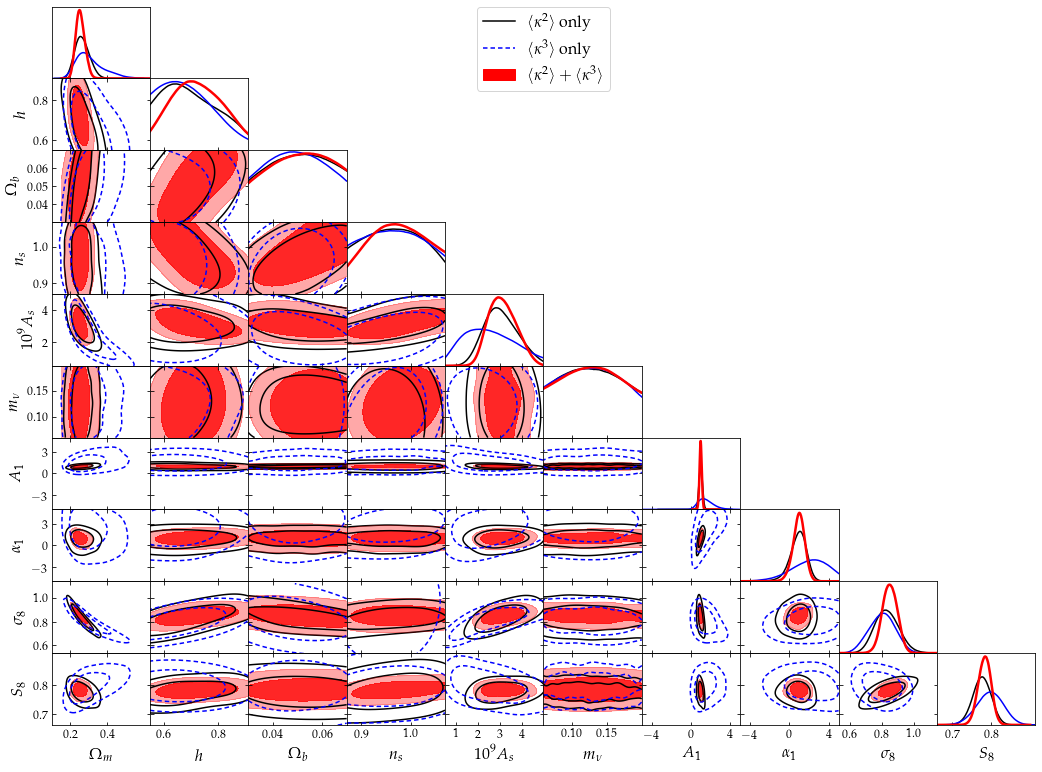

In [18]:
def replace_fancy(names, fancy_dic):
    output_names = []
    ind_data = []
    for ii in range(len(names)):
        if (names[ii] in fancy_dic):
            output_names.append(fancy_dic[names[ii]])
            ind_data.append(ii)
#         else:
#             output_names.append()
    return np.array(output_names), np.array(ind_data)


filename_list = [
    
    # '/global/cfs/cdirs/des/shivamp/cosmosis2p0/cosmosis-standard-library/output/GM_chains/kp2_kp3_allparams_auto_smbin_gtsc_MOPED_inf15p.txt',      
    # '/global/cfs/cdirs/des/shivamp/cosmosis2p0/cosmosis-standard-library/output/GM_chains/kp2_kp3_allparams_all_gtsc_MOPED_inf15p.txt',        
    
    # '/global/cfs/cdirs/des/shivamp/cosmosis2p0/cosmosis-standard-library/output/GM_chains/kp2_allparams_auto_smbin_gtsc_MOPED_inf15p.txt',      
    # '/global/cfs/cdirs/des/shivamp/cosmosis2p0/cosmosis-standard-library/output/GM_chains/kp2_allparams_all_gtsc_MOPED_inf15p.txt',        

    # '/global/cfs/cdirs/des/shivamp/cosmosis2p0/cosmosis-standard-library/output/GM_chains/kp3_allparams_auto_smbin_gtsc_MOPED_inf15p.txt',      
    # '/global/cfs/cdirs/des/shivamp/cosmosis2p0/cosmosis-standard-library/output/GM_chains/kp3_allparams_all_gtsc_MOPED_inf15p.txt',        

    
    # '/global/cfs/cdirs/des/shivamp/cosmosis2p0/cosmosis-standard-library/output/GM_chains/kp2_allparams_auto_smbin_gtsc_MOPED_inf15p.txt',      
    # '/global/cfs/cdirs/des/shivamp/cosmosis2p0/cosmosis-standard-library/output/GM_chains/kp3_allparams_auto_smbin_gtsc_MOPED_inf15p.txt',          
    # '/global/cfs/cdirs/des/shivamp/cosmosis2p0/cosmosis-standard-library/output/GM_chains/kp2_kp3_allparams_auto_smbin_gtsc_MOPED_inf15p.txt',          

    
    '/global/cfs/cdirs/des/shivamp/cosmosis2p0/cosmosis-standard-library/output/GM_chains/kp2_allparams_all_gtsc_MOPED_inf15p.txt',        
    '/global/cfs/cdirs/des/shivamp/cosmosis2p0/cosmosis-standard-library/output/GM_chains/kp3_allparams_all_gtsc_MOPED_inf15p.txt',                
    '/global/cfs/cdirs/des/shivamp/cosmosis2p0/cosmosis-standard-library/output/GM_chains/kp2_kp3_allparams_all_gtsc_MOPED_inf15p.txt',        
    
    
    
    # '/global/cfs/cdirs/des/shivamp/cosmosis2p0/cosmosis-standard-library/output/GM_chains/kp2_kp3_OmAsonly_auto_smbin_gtsc_MOPED_inf15p.txt',      
    # '/global/cfs/cdirs/des/shivamp/cosmosis2p0/cosmosis-standard-library/output/GM_chains/kp2_kp3_OmAsonly_all_gtsc_MOPED_inf15p.txt',        
    
    # '/global/cfs/cdirs/des/shivamp/cosmosis2p0/cosmosis-standard-library/output/GM_chains/kp2_OmAsonly_auto_smbin_gtsc_MOPED_inf15p.txt',      
    # '/global/cfs/cdirs/des/shivamp/cosmosis2p0/cosmosis-standard-library/output/GM_chains/kp2_OmAsonly_all_gtsc_MOPED_inf15p.txt',        

    # '/global/cfs/cdirs/des/shivamp/cosmosis2p0/cosmosis-standard-library/output/GM_chains/kp3_OmAsonly_auto_smbin_gtsc_MOPED_inf15p.txt',      
    # '/global/cfs/cdirs/des/shivamp/cosmosis2p0/cosmosis-standard-library/output/GM_chains/kp3_OmAsonly_all_gtsc_MOPED_inf15p.txt',        

    
    # '/global/cfs/cdirs/des/shivamp/cosmosis2p0/cosmosis-standard-library/output/GM_chains/kp2_OmAsonly_auto_smbin_gtsc_MOPED_inf15p.txt',      
    # '/global/cfs/cdirs/des/shivamp/cosmosis2p0/cosmosis-standard-library/output/GM_chains/kp3_OmAsonly_auto_smbin_gtsc_MOPED_inf15p.txt',          
    # '/global/cfs/cdirs/des/shivamp/cosmosis2p0/cosmosis-standard-library/output/GM_chains/kp2_kp3_OmAsonly_auto_smbin_gtsc_MOPED_inf15p.txt',          

    
    # '/global/cfs/cdirs/des/shivamp/cosmosis2p0/cosmosis-standard-library/output/GM_chains/kp2_OmAsonly_all_gtsc_MOPED_inf15p.txt',        
    # '/global/cfs/cdirs/des/shivamp/cosmosis2p0/cosmosis-standard-library/output/GM_chains/kp3_OmAsonly_all_gtsc_MOPED_inf15p.txt',                
    # '/global/cfs/cdirs/des/shivamp/cosmosis2p0/cosmosis-standard-library/output/GM_chains/kp2_kp3_OmAsonly_all_gtsc_MOPED_inf15p.txt',        
    
    
    # '/global/cfs/cdirs/des/shivamp/cosmosis2p0/cosmosis-standard-library/output/GM_chains/kp3_autosm_all.txt',            
    # '/global/cfs/cdirs/des/shivamp/cosmosis2p0/cosmosis-standard-library/output/GM_chains/kp3_all.txt',        
    
    
    # '/global/cfs/cdirs/des/shivamp/boss_cosmosis/cosmosis/y3-3x2pt/chains/chain_2x2_0321.txt',
    # '/global/cfs/cdirs/des/shivamp/boss_cosmosis/cosmosis/y3-3x2pt/chains/chain_2x2pt_NLbias86_lcdm.txt',
    # '/global/cfs/cdirs/des/shivamp/boss_cosmosis/cosmosis/y3-3x2pt/chains/chain_2x2pt_NLbias44_lcdm.txt',
]

# legend_labels = [r'Linear Bias, (8,6)Mpc/$h$',r'Non-Linear Bias, (8,6)Mpc/$h$',r'Non-Linear Bias, (4,4)Mpc/$h$','DES Y1, 2x2pt', 'Planck 2018']
# legend_labels = [r'Auto $\theta$ bins', 'Generalized moments',r'Linear Bias, (8,6)Mpc/$h$',r'Non-Linear Bias, (8,6)Mpc/$h$',r'Non-Linear Bias, (4,4)Mpc/$h$']
# legend_labels = ['with scale cuts','All scales',r'Linear Bias, (8,6)Mpc/$h$',r'Non-Linear Bias, (8,6)Mpc/$h$',r'Non-Linear Bias, (4,4)Mpc/$h$']
legend_labels = [r'$\langle \kappa^2 \rangle$ only',r'$\langle \kappa^3 \rangle$ only',r'$\langle \kappa^2 \rangle + \langle \kappa^3 \rangle$',r'Linear Bias, (8,6)Mpc/$h$',r'Non-Linear Bias, (8,6)Mpc/$h$',r'Non-Linear Bias, (4,4)Mpc/$h$']

ext_b1b2 = [0,0,0,0]

all_data = []
all_samples = []

fancy_dictionary = {
    'cosmological_parameters--s8':r'$S_8$','cosmological_parameters--omega_m':r'$\Omega_m$', 'COSMOLOGICAL_PARAMETERS--SIGMA_8':r'$\sigma_8$', 
#     'bias_lens--rmean_bin':r'$X$',
#     'cosmological_parameters--omega_m':r'$\Omega_m$','cosmological_parameters--s8':r'$S_8$' ,'COSMOLOGICAL_PARAMETERS--SIGMA_8':r'$\sigma_8$', 
                    'cosmological_parameters--mnu':r'$m_{\nu}$','cosmological_parameters--a_s':r'$10^9 A_s$',
                    'cosmological_parameters--h0':r'$h$',	'cosmological_parameters--omega_b':r'$\Omega_b$',	'cosmological_parameters--n_s':r'$n_s$',
                    'bias_lens--b1':r'$b_1$',	'bias_lens--b2':r'$b_2$',	'bias_lens--b3':r'$b_3$',	'bias_lens--b4':r'$b_4$',	'bias_lens--b5':r'$b_5$',
#                     'bias_lens--b1e_sig8_bin1':r'$\sigma_8 b_1$',	'bias_lens--b1e_sig8_bin2':r'$\sigma_8 b_2$',	'bias_lens--b1e_sig8_bin3':r'$\sigma_8 b_3$',	'bias_lens--b1e_sig8_bin4':r'$\sigma_8 b_4$',	'bias_lens--b1e_sig8_bin5':r'$\sigma_8 b_5$',
#     'bias_lens--sqrtbisig8_1':r'$\sigma_8 \sqrt{b_1}$',	'bias_lens--sqrtbisig8_2':r'$\sigma_8 \sqrt{b_2}$',	'bias_lens--sqrtbisig8_3':r'$\sigma_8 \sqrt{b_3}$',	'bias_lens--sqrtbisig8_4':r'$\sigma_8 \sqrt{b_4}$',	'bias_lens--sqrtbisig8_5':r'$\sigma_8 \sqrt{b_5}$',
#      'bias_lens--sqrtbisig8S8_1':r'$\sqrt{b_1 \sigma_8 S_8}$',	'bias_lens--sqrtbisig8S8_2':r'$\sqrt{b_2 \sigma_8 S_8}$',	'bias_lens--sqrtbisig8S8_3':r'$\sqrt{b_3 \sigma_8 S_8}$',	'bias_lens--sqrtbisig8S8_4':r'$\sqrt{b_4 \sigma_8 S_8}$',	'bias_lens--sqrtbisig8S8_5':r'$\sqrt{b_5 \sigma_8 S_8}$',
#                     'add_pm--b_1':r'$B_1$',	'add_pm--b_2':r'$B_2$',	'add_pm--b_3':r'$B_3$',	'add_pm--b_4':r'$B_4$',	'add_pm--b_5':r'$B_5$',
                   'intrinsic_alignment_parameters--a1':r'$A_1$','intrinsic_alignment_parameters--a2':r'$A_2$',	
                    'intrinsic_alignment_parameters--alpha1':r'$\alpha_1$',	'intrinsic_alignment_parameters--alpha2':r'$\alpha_2$',	'intrinsic_alignment_parameters--bias_ta':r'$b_{\rm ta}$'
                   } 

ranges = {
    'cosmological_parameters--omega_m':[0.1,0.9],
#     'bias_lens--rmean_bin':r'$X$',
#     'cosmological_parameters--omega_m':r'$\Omega_m$','cosmological_parameters--s8':r'$S_8$' ,'COSMOLOGICAL_PARAMETERS--SIGMA_8':r'$\sigma_8$', 
                    'cosmological_parameters--mnu':[0.06,0.2],'cosmological_parameters--a_s':[0.5,5.0],
                    'cosmological_parameters--h0':[0.55,0.91],	'cosmological_parameters--omega_b':[0.03,0.07],	'cosmological_parameters--n_s':[0.87,1.07],
                    'bias_lens--b1':[0.8,3.0],	'bias_lens--b2':[0.8,3.0],	'bias_lens--b3':[0.8,3.0],	'bias_lens--b4':[0.8,3.0],	'bias_lens--b5':[0.8,3.0],
#                     'bias_lens--b1e_sig8_bin1':r'$\sigma_8 b_1$',	'bias_lens--b1e_sig8_bin2':r'$\sigma_8 b_2$',	'bias_lens--b1e_sig8_bin3':r'$\sigma_8 b_3$',	'bias_lens--b1e_sig8_bin4':r'$\sigma_8 b_4$',	'bias_lens--b1e_sig8_bin5':r'$\sigma_8 b_5$',
#     'bias_lens--sqrtbisig8_1':r'$\sigma_8 \sqrt{b_1}$',	'bias_lens--sqrtbisig8_2':r'$\sigma_8 \sqrt{b_2}$',	'bias_lens--sqrtbisig8_3':r'$\sigma_8 \sqrt{b_3}$',	'bias_lens--sqrtbisig8_4':r'$\sigma_8 \sqrt{b_4}$',	'bias_lens--sqrtbisig8_5':r'$\sigma_8 \sqrt{b_5}$',
#      'bias_lens--sqrtbisig8S8_1':r'$\sqrt{b_1 \sigma_8 S_8}$',	'bias_lens--sqrtbisig8S8_2':r'$\sqrt{b_2 \sigma_8 S_8}$',	'bias_lens--sqrtbisig8S8_3':r'$\sqrt{b_3 \sigma_8 S_8}$',	'bias_lens--sqrtbisig8S8_4':r'$\sqrt{b_4 \sigma_8 S_8}$',	'bias_lens--sqrtbisig8S8_5':r'$\sqrt{b_5 \sigma_8 S_8}$',
#                     'add_pm--b_1':r'$B_1$',	'add_pm--b_2':r'$B_2$',	'add_pm--b_3':r'$B_3$',	'add_pm--b_4':r'$B_4$',	'add_pm--b_5':r'$B_5$',
                   'intrinsic_alignment_parameters--a1':[-5.0,5.0],'intrinsic_alignment_parameters--a2':[-5.0,5.0],	
                    'intrinsic_alignment_parameters--alpha1':[-5.0,5.0],	'intrinsic_alignment_parameters--alpha2':[-5.0,5.0],	'intrinsic_alignment_parameters--bias_ta':[0.0,2.0]
                   } 


# fancy_dictionary = {'cosmological_parameters--omega_m':r'$\Omega_m$','cosmological_parameters--omega_mcb':r'$\Omega_m - \Omega_{\nu}$','cosmological_parameters--s8':r'$S_8$','cosmological_parameters--omnuh2':r'$\Omega_{\nu} h^2$'}  
# fancy_dictionary = {'cosmological_parameters--omega_m':r'$\Omega_m$','cosmological_parameters--omega_mcb':r'$\Omega_m - \Omega_{\nu}$','cosmological_parameters--s8':r'$S_8$','cosmological_parameters--omnuh2':r'$\Omega_{\nu} h^2$'}  
# fancy_dictionary = {'cosmological_parameters--omega_m':r'$\Omega_m$','cosmological_parameters--s8':r'$S_8$'} 
# fancy_dictionary = {'cosmological_parameters--omega_m':r'$\Omega_m$','COSMOLOGICAL_PARAMETERS--SIGMA_8':r'$\sigma_8$'} 
# fancy_dictionary = {'cosmological_parameters--omega_m':r'$\Omega_m$','cosmological_parameters--mnu':r'$m_{\nu}$'} 

for fi in range(0,len(filename_list)):
    filename = filename_list[fi]
    try:
        nsample = get_nsample(filename)
    except:
        nsample = np.loadtxt(filename).shape[0]
    data = np.loadtxt(filename)[-nsample:,:]
    weights = np.loadtxt(filename)[-nsample:,-1]
    param_names = get_param_names(filename)
    for ii in range(len(param_names)):
        if (param_names[ii] in ['cosmological_parameters--a_s']):
            as_ind = ii
    data[:,as_ind] = (10**9) * data[:,as_ind]     
    
    
    s8 = get_S8(data, param_names).reshape(data.shape[0],1)
    data = np.hstack((data,s8))
    param_names = np.append(param_names,'cosmological_parameters--s8')
        
    param_names_fancy, selection = replace_fancy(np.array(param_names), fancy_dictionary)
    
    data = data[:,selection]
    param_names = param_names[selection]
    param_names_fancy = param_names_fancy
    all_data.append(data)

    samples = MCSamples(samples=data,\
                        weights=weights, ranges=ranges, \
                        names = param_names, labels = param_names_fancy)
    all_samples.append(samples)
    marge = samples.getMargeStats()
    for j1 in range(len(param_names)):
        paramj1 = param_names[j1]
        r_marge = marge.parWithName(paramj1)
        r_mean = r_marge.mean
        # print(paramj1 + ': ' + str(r_mean) + ', ' + str(r_mean - r_marge.limits[0].lower) + ', ' + str(r_marge.limits[0].upper -  r_mean))
#         Om_err[keyv] = np.array([r_marge.limits[0].lower,r_marge.limits[0].upper])
#         print('Bin ' + str(j1+1) + ': ' + str(r_marge.limits[0].lower) + ', ' + str(r_marge.mean) + ', ' + str(r_marge.limits[0].upper))
    

#     print("nsamp  = ", nsample)
#     print("data shape = ", data.shape)
#     print( "weights shape = ", weights.shape)
#     print( "param names = ", param_names)
#     print( "param names fancy = ", param_names_fancy)


fig_save_dir = './paper_figs/'
# pl.rc('text.latex')

# param_limits = {'$\sigma8$':[0.7, 0.9]}

g = plots.getSinglePlotter(width_inch =15)
# g.settings.auto_ticks = True
g.settings.axes_fontsize   = 16
g.settings.lab_fontsize    = 20
g.settings.legend_fontsize = 20
g.settings.axis_marker_lw = 2.0

# marker_dict = {'cosmological_parameters--omega_m':0.3,'cosmological_parameters--omega_mcb':Om_cb,'COSMOLOGICAL_PARAMETERS--SIGMA_8':0.8235,'cosmological_parameters--s8':s8v,'cosmological_parameters--omega_b':0.048,'cosmological_parameters--h0':0.69,'cosmological_parameters--n_s':0.97,'cosmological_parameters--w':-1.0, 'cosmological_parameters--omnuh2':0.00083 ,'pk_to_cl--b1e_bin1':1.7,'pk_to_cl--b1e_bin2':1.7,'pk_to_cl--b1e_bin3':1.7,'pk_to_cl--b1e_bin4':2.0,'pk_to_cl--b1e_bin5':2.0,'pk_to_cl--b2e_bin1':0.23,'pk_to_cl--b2e_bin2':0.23,'pk_to_cl--b2e_bin3':0.23,'pk_to_cl--b2e_bin4':0.5,'pk_to_cl--b2e_bin5':0.5}    
# g.plot_2d(all_samples,'cosmological_parameters--omega_m','cosmological_parameters--s8', legend_labels = legend_labels, line_args=[{'lw':2.5,'color':'black'},{'lw':2.5,'color':'blue'},{'lw':2.5,'color':'red'},{'lw':2.5,'color':'green'}],contour_lws=[1.5],  filled = [False, False,True, False], contour_colors = ['black','blue','red','green'],ls=['-','--','-.'],lims=[0.2,0.52,0.55,0.85])  
# lims = [0.16,0.53,0.65,0.92]
# lims = [0.2,0.355,0.7,0.85]
# g.plot_2d(all_samples,'cosmological_parameters--omega_m','cosmological_parameters--s8', legend_labels = legend_labels, line_args=[{'lw':2.5,'color':'black'},{'lw':2.5,'color':'blue'},{'lw':2.5,'color':'red'},{'lw':2.5,'color':'green'},{'lw':2.5,'color':'orange'}],contour_lws=[1.5],  filled = [False, False,True, True, True], contour_colors = ['black','blue','red','green','orange'],ls=['-','--','-.','-','-'],lims=lims)  
# g.plot_2d(all_samples,'cosmological_parameters--omega_m','COSMOLOGICAL_PARAMETERS--SIGMA_8', legend_labels = legend_labels, line_args=[{'lw':2.5,'color':'green'},{'lw':2.5,'color':'orange'},{'lw':2.5,'color':'black'},{'lw':2.5,'color':'blue'},{'lw':2.5,'color':'red'}],contour_lws=[1.5],  filled = [True, True,False, False,True], contour_colors = ['green','orange','black','blue','red'],ls=['-','-','-','--','-.'])  
# g.triangle_plot(all_samples, legend_labels = legend_labels, markers=marker_dict,  filled = [True,  True,True])  
# g.triangle_plot(all_samples,diag1d_kwargs={'normalized':True}, legend_labels = legend_labels,   line_args=[{'lw':1.5, 'ls':'-','color':'black'},{'lw':1.5, 'ls':'-','color':'blue'},{'lw':2.5,'color':'black'},{'lw':2.5,'color':'green'}],contour_lws=[1.5,1.5,2.5], filled=[False, False,False, False], contour_colors=['black','blue','black','green'], ls=['-','--','-','-'])
g.triangle_plot(all_samples,diag1d_kwargs={'normalized':True}, legend_labels = legend_labels,   line_args=[{'lw':1.5, 'ls':'-','color':'black'},{'lw':1.5, 'ls':'-','color':'blue'},{'lw':1.5,'color':'red'},{'lw':2.5,'color':'green'}],contour_lws=[1.5,1.5,2.5], filled=[False, False,True, False], contour_colors=['black','blue','red','green'], ls=['-','--','-','-'])
# g.add_x_marker(0.26)
# g.add_y_marker(0.84*(0.26/0.3)**(0.5))
# g.add_y_marker(0.84)
# g.add_legend(legend_labels, legend_loc='lower right',fontsize=18)

# pl.title(r'Auto $\theta$ bins', size=22)
# pl.title(r'Generalized moments', size=22)
# pl.title(r'$\langle \kappa^2 \rangle + \langle \kappa^3 \rangle$', size=22)
# pl.title(r'$\langle \kappa^3 \rangle$ only', size=22)
# pl.title(r'$\langle \kappa^2 \rangle$ only', size=22)
# pl.savefig('all_params_kp3_only.pdf')
# pl.savefig('all_params_kp2_kp3.pdf')
pl.savefig('all_params_genmoments.pdf')
pl.show()






In [3]:
df = pk.load(open('/global/cfs/cdirs/des/shivamp/cosmosis2p0/cosmosis-standard-library/log_derv_allparams.pk','rb'))  
# saved = {'dlogkp2_dlogparams':dlogkp2_dlogparams, 'dlogkp3_dlogparams':dlogkp3_dlogparams}


In [4]:
dlogkp2_dlogparams = df['dlogkp2_dlogparams']
dlogkp3_dlogparams = df['dlogkp3_dlogparams']



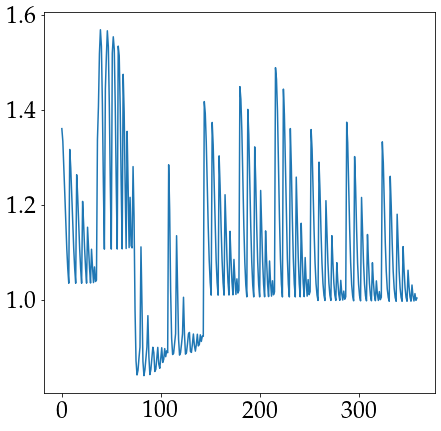

In [7]:
pl.figure()
pl.plot(dlogkp2_dlogparams[4,:])



(0, 2400)

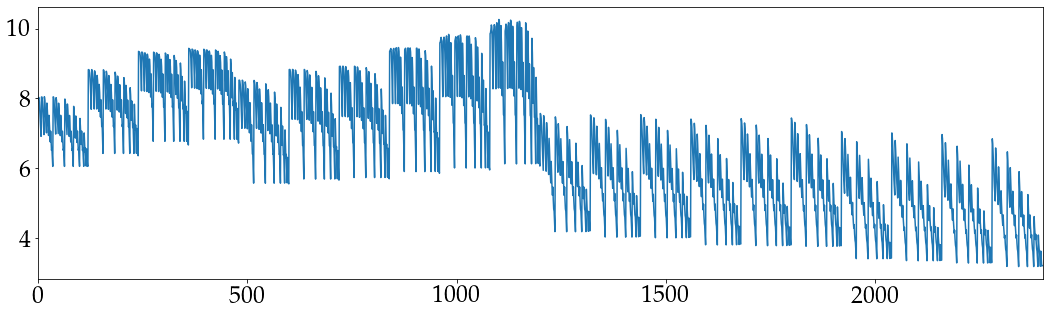

In [12]:
pl.figure(figsize=(18,5))
pl.plot(dlogkp3_dlogparams[0,:])
pl.xlim(0,2400)


